In [1]:
# imports

from functools import reduce
import itertools
import matplotlib as mpl
from matplotlib import pyplot as plt
from barnacle import plot_factors_heatmap
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import string
import tensorly as tl
from tensorly.cp_tensor import CPTensor
import tlviz
from tlviz.factor_tools import factor_match_score
from tlab.cp_tensor import load_cp_tensor
import xarray as xr
from barnacle.tensors import SparseCPTensor


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300


In [3]:
# helpful functions
    
# function to select subset of indices in cp tensor
def subset_cp_tensor(cp_tensor, subset_indices):
    '''Selects subset of cp_tensor based on provided indices
    
    Parameters
    ----------
    cp_tensor : tensorly.CPTensor
        CPTensor object with (weights, factors).
    subset_indices : dict(int: index-like)
        Dictionary with mode as key and value an integer index of 
        the positions to be downselected from `cp_tensor`.
        Example: {1: [0, 1, 3, 4, 5, 8]}
        
    Returns
    -------
    subset_cp : tensorly.CPTensor
        Subset CPTensor.
    '''
    weights, factors = cp_tensor
    new_factors = factors.copy()
    for mode, index in subset_indices.items():
        new_factors[mode] = factors[mode][index]
    return(CPTensor((weights, new_factors)))

# unique bin function
def unique_bins(array, n_bins, bounds=None, reverse=False):
    '''This is a function that maps an array of continuous values with potential duplicates to 
    a set of bins in such a way that each of the original continuous values is mapped to a unique bin, and the
    distribution of binned values approximates the distribution of continuous values as closely as possible.
    
    My quick and dirty approach to this problem sorts the input array into the appropriate number of bins. Then,
    starting in the middle and alternating outward left and right, the algorithm checks to see if each bin has 
    more than one resident. If so, it will again alternate outward left and right from that position and allocate
    the extra residents to the nearest free bins.
    
    Parameters
    ----------
    array : np.array
        Sorted array of values to be placed into bins.
    n_bins : int
        Number of bins to use.
    bounds : (float, float)
        Upper and lower bounds to use for bin-mapping.
    reverse : bool
        Optional flag to reverse the index ordering of the output.
    
        
    Returns
    -------
    index : np.array
        Indices indicating mapping of input values to bins, where index[i] indicates the index of the bin 
        mapping of input value array[i] (assuming input array is sorted).
    '''
    # check number of bins
    if not n_bins >= len(array):
        raise ValueError('The number of bins must be >= len(array).')
    # add bounds if supplied
    if bounds is not None:
        array = np.concatenate((array, bounds))
    # make histogram
    counts, _ = np.histogram(array, bins=n_bins)
    # remove bounds if added
    if bounds is not None:
        counts[0] -= 1
        counts[-1] -= 1
    # start from the middle
    i = int(n_bins/2)
    for j in range(n_bins):
        # alternate left and right
        if j % 2:
            i -= j
        else:
            i += j
        # resolve collisions
        if counts[i] > 1:
            # set new counter for exploring nearby positions
            k = i
            for l in range(2*n_bins):
                # alternate left and right
                if l % 2:
                    k -= l
                else:
                    k += l
                # check if we're still in range
                if 0 <= k < n_bins:
                    # check for an empty spot
                    if counts[k] == 0:
                        counts[k] = 1
                        counts[i] -= 1
                        # check if all collisions have been resolved yet
                        if counts[i] == 1:
                            break
    # select indices of non-zero values
    index = np.where(counts == 1)[0]
    # reverse if requested
    if reverse:
        index = (n_bins - 1) - index
    return index


# import data

In [4]:
# select the cluster to examine

genus = 'syn'
clusters = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]    # high priority clusters
rank = 15
lamb = 10. 
bootstraps = np.arange(100)
replicates = ['A', 'B', 'C']

# determined in component-robustness.ipynb analysis
best_reps = {
    'pro': {'rank': 15, 'lambda': 16., 'boot': 65, 'rep': 'B'}, 
    'syn': {'rank': 15, 'lambda': 10., 'boot': 72, 'rep': 'A'}
}

datapath = Path('../../data/4-fitting/{}'.format(genus))
outdir = Path('./{}'.format(genus))


In [5]:
# fetch sample metatdata and shuffled sample label inputs

filepath_metadata_sample = '../../data/metadata/archive/sample_metadata_merged.csv'
metadata_sample_df = pd.read_csv(filepath_metadata_sample).fillna('')
metadata_sample_df['datetime'] = pd.to_datetime(metadata_sample_df['datetime'], dayfirst=True)

# collect sample names of each bootstrap/replicate pair
samplenames = {}
for boot in bootstraps:
    samplenames[boot] = {}
    for rep in replicates:
        ds = xr.open_dataset(datapath / 'bootstrap{}/replicate{}/shuffled-replicate-{}.nc'.format(boot, rep, rep))
        samplenames[boot][rep] = ds.SampleName.data

# collect common samplenames (present in each bootstrap)
samplenames['common'] = reduce(
    np.intersect1d, 
    [samplenames[b][r] for b, r in list(itertools.product(bootstraps, replicates))]
)

tensor_ds = xr.open_dataset(datapath / 'bootstrap{}/dataset-bootstrap{}.nc'.format(bootstraps[0], bootstraps[0]))

tensor_ds


/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/2680685062.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  metadata_sample_df['datetime'] = pd.to_datetime(metadata_sample_df['datetime'], dayfirst=True)


<xarray.Dataset>
Dimensions:     (Ortholog: 6478, Clade: 7, Sample: 222)
Coordinates:
  * Ortholog    (Ortholog) int64 60000001 60000002 ... 60040245 60040265
  * Clade       (Clade) object '5.1A-CRD2' '5.1A-II' ... '5.1B-CRD1' '5.1B-I'
  * Sample      (Sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    ReadCount   (Ortholog, Clade, Sample) float64 ...
    Residual    (Ortholog, Clade, Sample) float64 ...
    Replicate   (Sample) object ...
    SampleName  (Sample) object ...
    Annotation  (Ortholog) object ...
Attributes:
    ShuffleSeed:  2150143856

In [6]:
# import fitted models

cps = {}    # model as saved on computer
aligned_cps = {}    # aligned to best representative, all samples present
subset_aligned_cps = {}    # aligned to best representative, subset to just common samples

# read in best representative reference cp
path_ref_cp = 'bootstrap{}/replicate{}/rank{}/lambda{}/fitted-model.h5'.format(
    best_reps[genus]['boot'], best_reps[genus]['rep'], best_reps[genus]['rank'], best_reps[genus]['lambda']
)
cps['ref'] = tl.cp_normalize(load_cp_tensor(datapath / path_ref_cp))
# subset ref cp to common samplenames
idx = np.where(np.isin(
    samplenames[best_reps[genus]['boot']][best_reps[genus]['rep']], samplenames['common']
))[0]
subset_aligned_cps['ref'] = subset_cp_tensor(cps['ref'], {2: idx})
# arrange components in descending order of explained variance
subset_aligned_cps['ref'] = tlviz.factor_tools.permute_cp_tensor(
    subset_aligned_cps['ref'], 
    consider_weights=False
)

# read in the rest of the cp tensor models
for boot in bootstraps:
    cps[boot] = {}
    aligned_cps[boot] = {}
    subset_aligned_cps[boot] = {} 
    for rep in replicates:
        path_cp = 'bootstrap{}/replicate{}/rank{}/lambda{}/fitted-model.h5'.format(
            boot, rep, rank, lamb
        )
        # store normalized cp tensor to cps
        cps[boot][rep] = tl.cp_normalize(load_cp_tensor(datapath / path_cp))
        # pull out aligned cps
        idx = np.where(np.isin(samplenames[boot][rep], samplenames['common']))[0]
        subset_aligned_cps[boot][rep] = subset_cp_tensor(cps[boot][rep], {2: idx})
        # permute components to line up with best representative reference cp
        perm = tlviz.factor_tools.get_cp_permutation(
            subset_aligned_cps[boot][rep], 
            reference_cp_tensor=subset_aligned_cps['ref'], 
            consider_weights=False
        )
        subset_aligned_cps[boot][rep] = tlviz.factor_tools.permute_cp_tensor(
            subset_aligned_cps[boot][rep], 
            permutation=perm
        )
        aligned_cps[boot][rep] = tlviz.factor_tools.permute_cp_tensor(
            cps[boot][rep], 
            permutation=perm
        )

print(cps[0]['A'])
print(aligned_cps[0]['A'])
print(subset_aligned_cps[0]['A'])


(weights, factors) : rank-15 CPTensor of shape (6478, 7, 75)
(weights, factors) : rank-15 CPTensor of shape (6478, 7, 75)
(weights, factors) : rank-15 CPTensor of shape (6478, 7, 55)


# Plot component weights
- Aggregate weights for each component
- Make & save plot
- Save weights

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


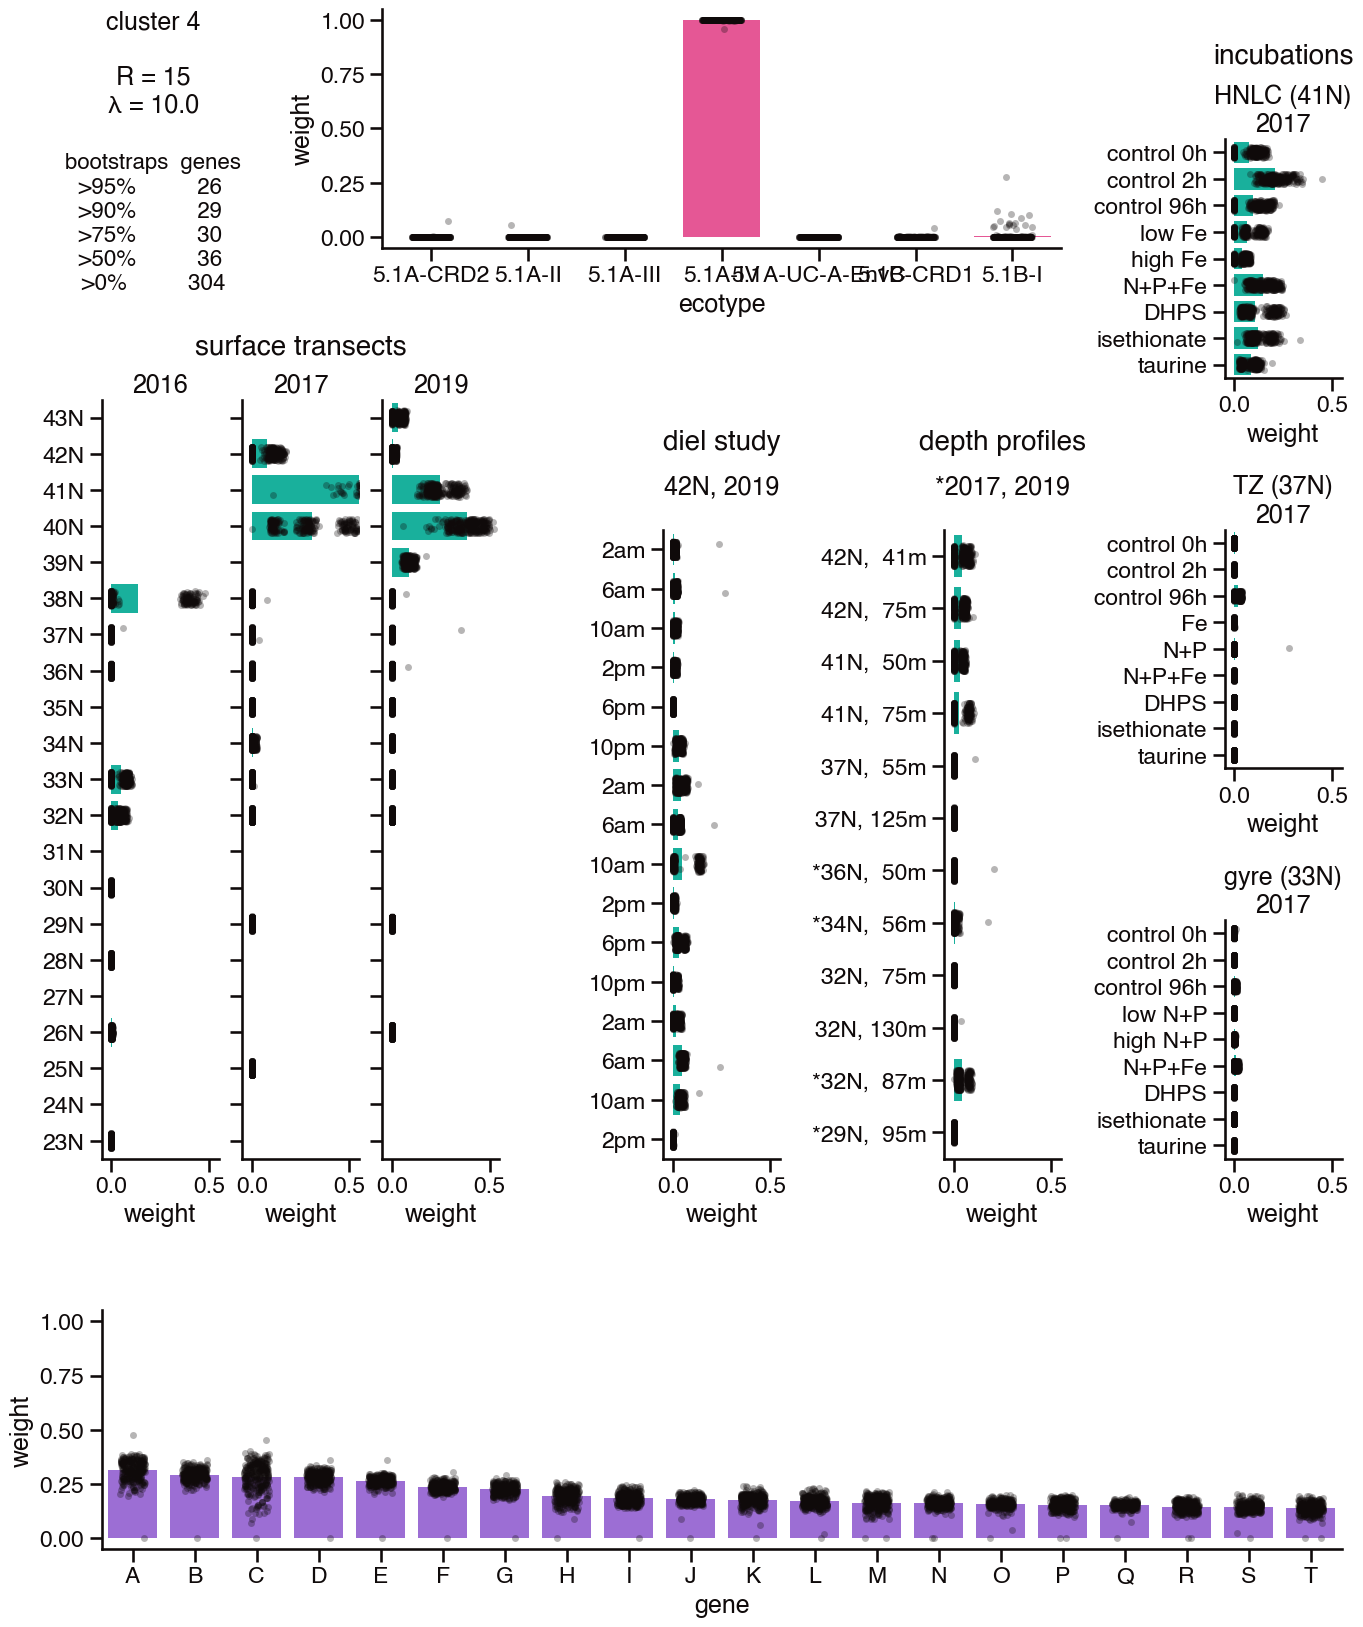

   gene     cycog                                         annotation  \
0     A  60021198              citronellol/citronellal dehydrogenase   
1     B  60029856  periplasmic chaperone for outer membrane prote...   
2     C  60032022          DNA-directed RNA polymerase subunit omega   
3     D  60015661                   ribulose-5-phosphate 3-epimerase   
4     E  60022412                              GTP pyrophosphokinase   
5     F  60034122                  O-sialoglycoprotein endopeptidase   
6     G  60023953                                           RNAse PH   
7     H  60035087  LPS assembly outer membrane protein LptD (orga...   
8     I  60029520                          dihydroneopterin aldolase   
9     J  60029857           Phosphotransferase enzyme family protein   
10    K  60024415                     aspartate carbamoyltransferase   
11    L  60011965                               hypothetical protein   
12    M  60025955  NAD(P)-dependent dehydrogenase, short-chain a

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


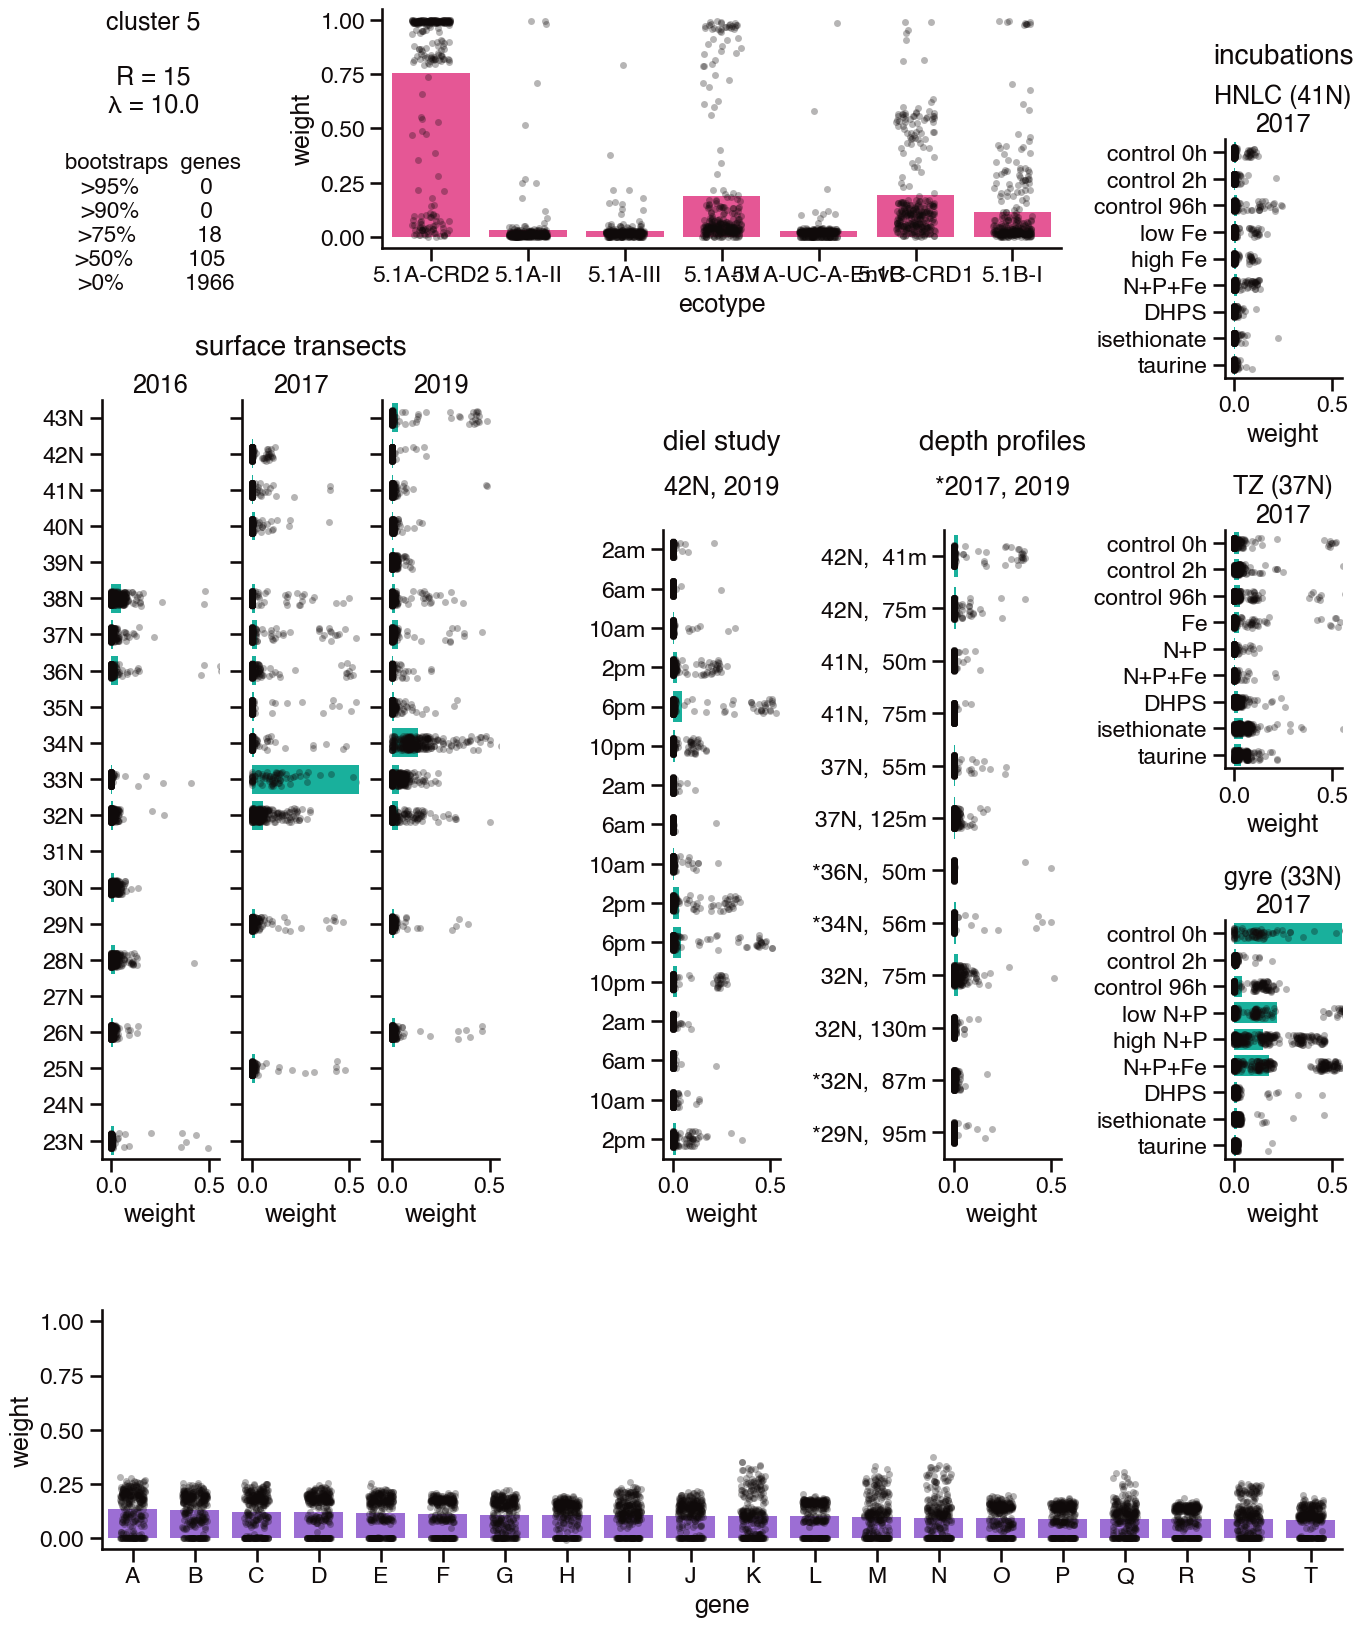

   gene     cycog                                         annotation  \
0     A  60004205                                   gluconolactonase   
1     B  60004814                               hypothetical protein   
2     C  60004180                               hypothetical protein   
3     D  60003600  Mannose or cellobiose epimerase, N-acyl-D-gluc...   
4     E  60003709                            glycogen operon protein   
5     F  60005614                   FG-GAP repeat-containing protein   
6     G  60004700            Putative intracellular protease/amidase   
7     H  60000573  6-phosphogluconate dehydrogenase (decarboxylat...   
8     I  60005789  Polyketide cyclase / dehydrase and lipid trans...   
9     J  60000595                                      transaldolase   
10    K  60000194   cytochrome c oxidase assembly protein subunit 15   
11    L  60007574              Ketosteroid isomerase-related protein   
12    M  60000170                   protoheme IX farnesyltransfe

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


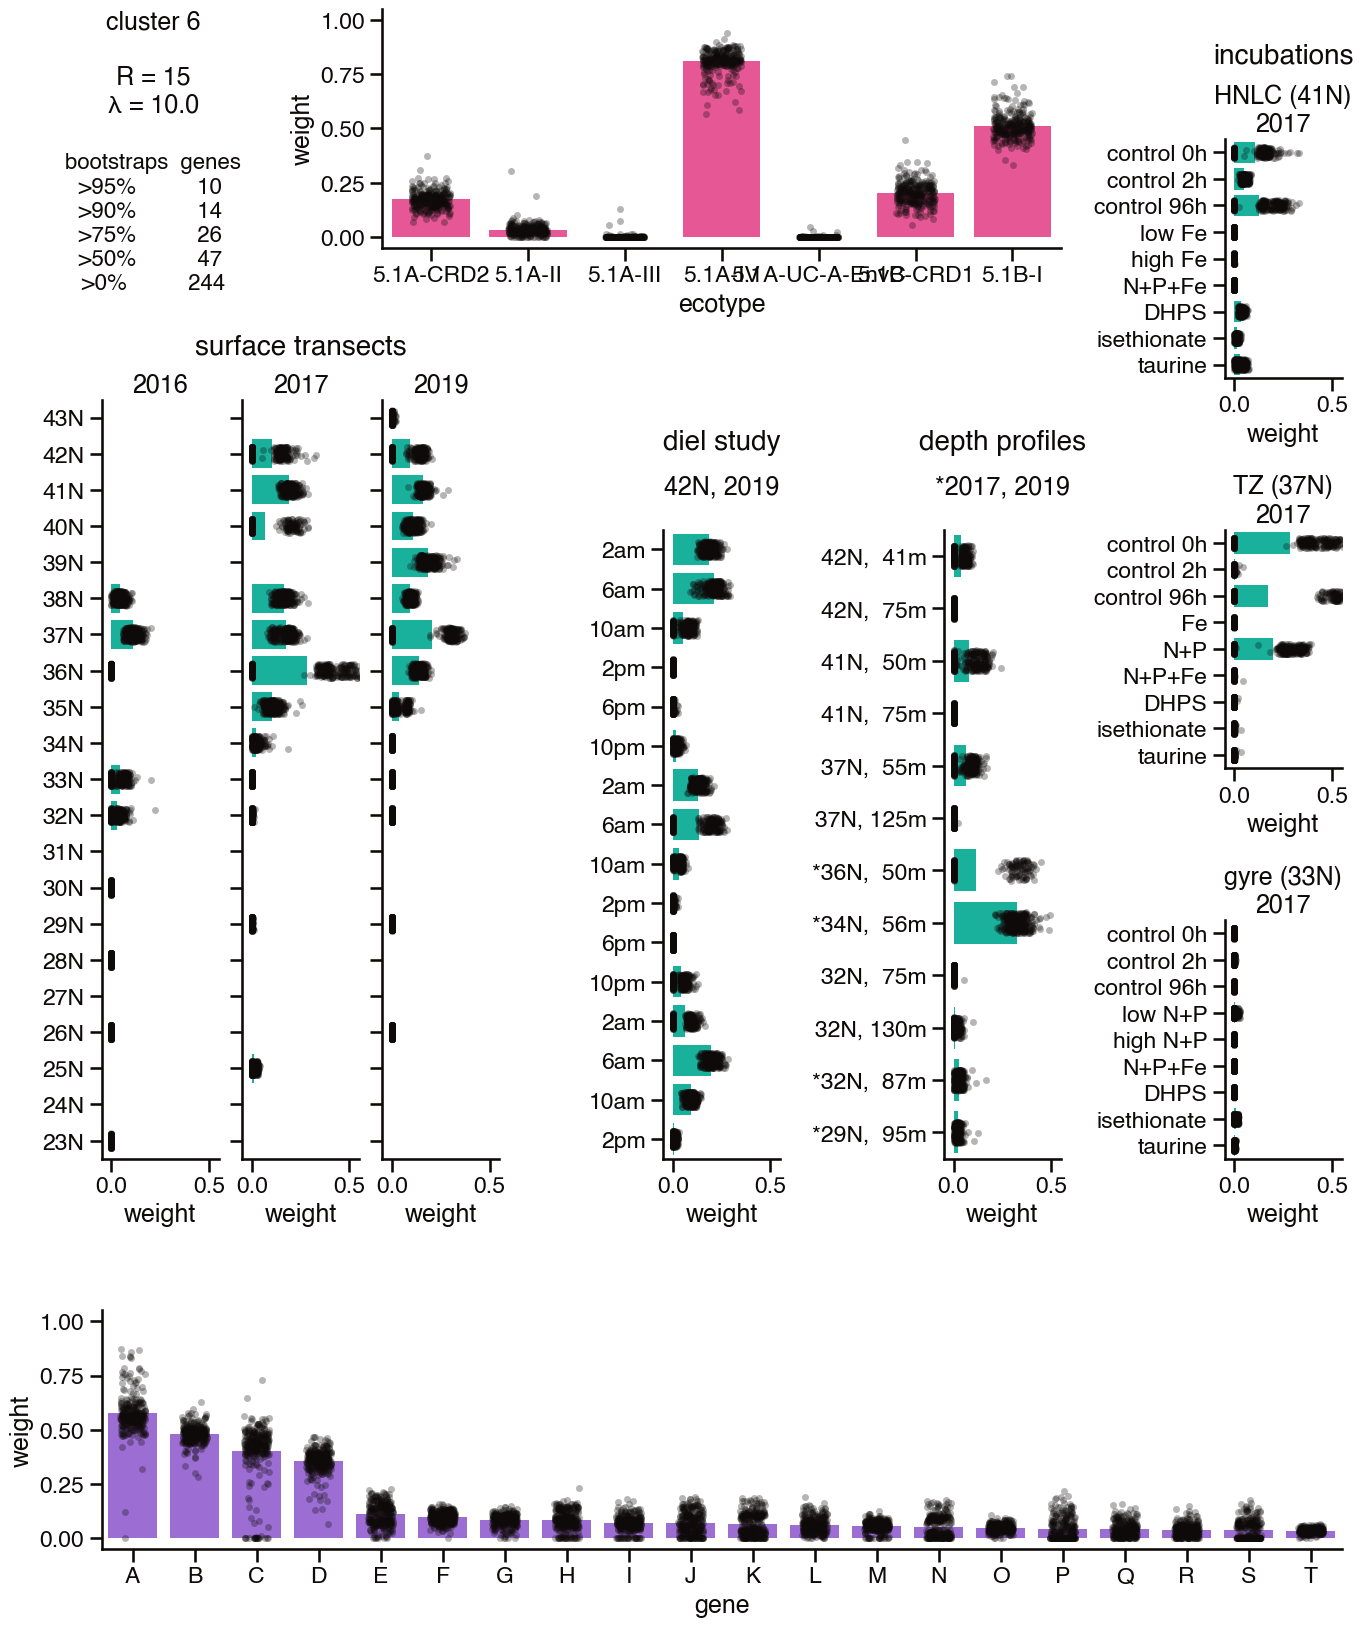

   gene     cycog                                         annotation  \
0     A  60001112                                       flavodoxin I   
1     B  60000023  chlorophyll a/b binding light-harvesting prote...   
2     C  60001290                     fructose-bisphosphate aldolase   
3     D  60002623                               hypothetical protein   
4     E  60002950         Pimeloyl-ACP methyl ester carboxylesterase   
5     F  60000706  iron(III) transport system substrate-binding p...   
6     G  60000103                      thioredoxin reductase (NADPH)   
7     H  60003170                               hypothetical protein   
8     I  60000321                          inorganic pyrophosphatase   
9     J  60003403  Uncharacterized membrane protein YphA, DoxX/SU...   
10    K  60003640                               hypothetical protein   
11    L  60000551           ATP synthase F1 subcomplex gamma subunit   
12    M  60000764            glucose-1-phosphate adenylyltransfe

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


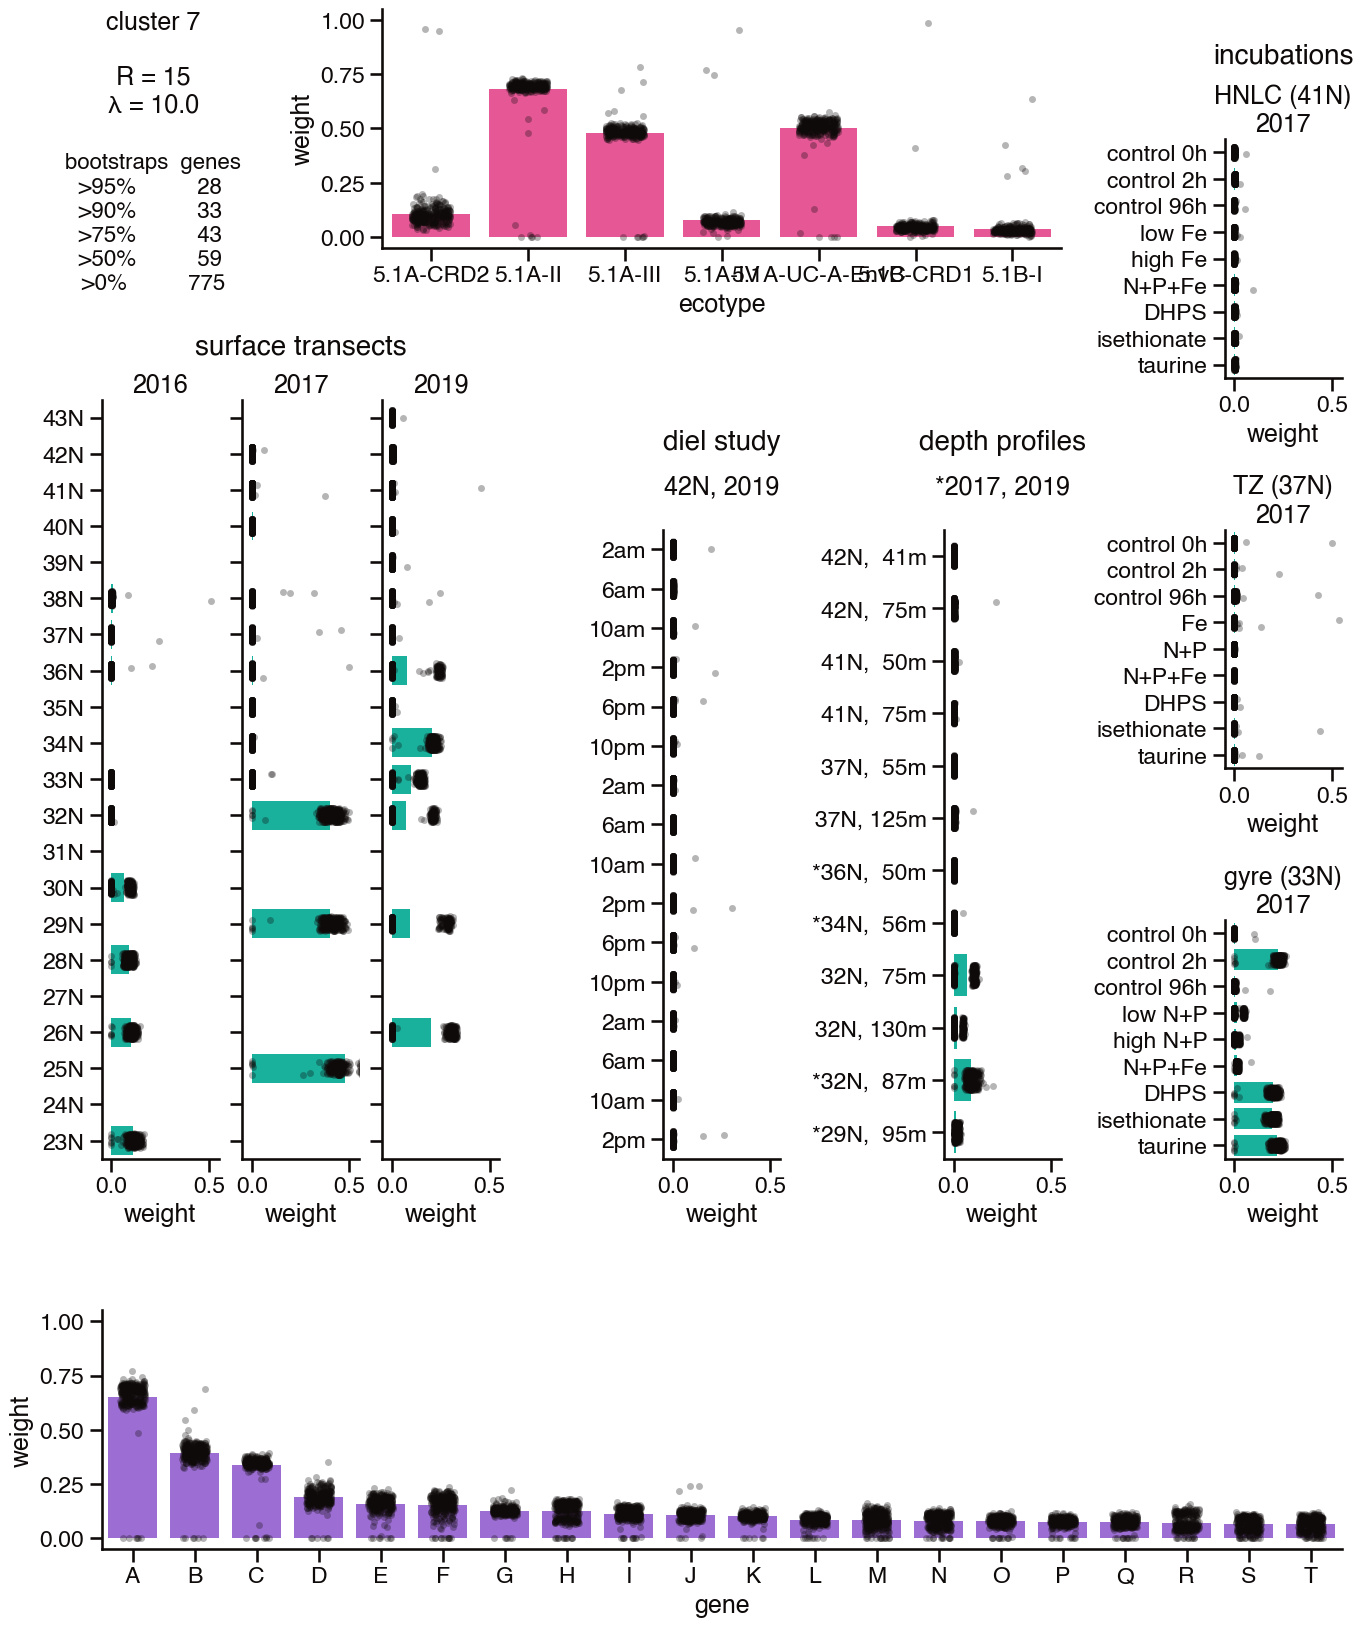

   gene     cycog                                         annotation  \
0     A  60002292            phycoerythrin-associated linker protein   
1     B  60001652                          phycoerythrin alpha chain   
2     C  60001630                           phycoerythrin beta chain   
3     D  60000087     photosystem I P700 chlorophyll a apoprotein A1   
4     E  60000298                AbrB-like transcriptional regulator   
5     F  60001535              protein of unknown function (DUF4278)   
6     G  60000242          polyribonucleotide nucleotidyltransferase   
7     H  60000501                            photosystem I subunit 2   
8     I  60000650                            photosystem I subunit 3   
9     J  60000004                               hypothetical protein   
10    K  60002680                            phycocyanin alpha chain   
11    L  60000626                                       plastocyanin   
12    M  60004832                               hypothetical pro

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


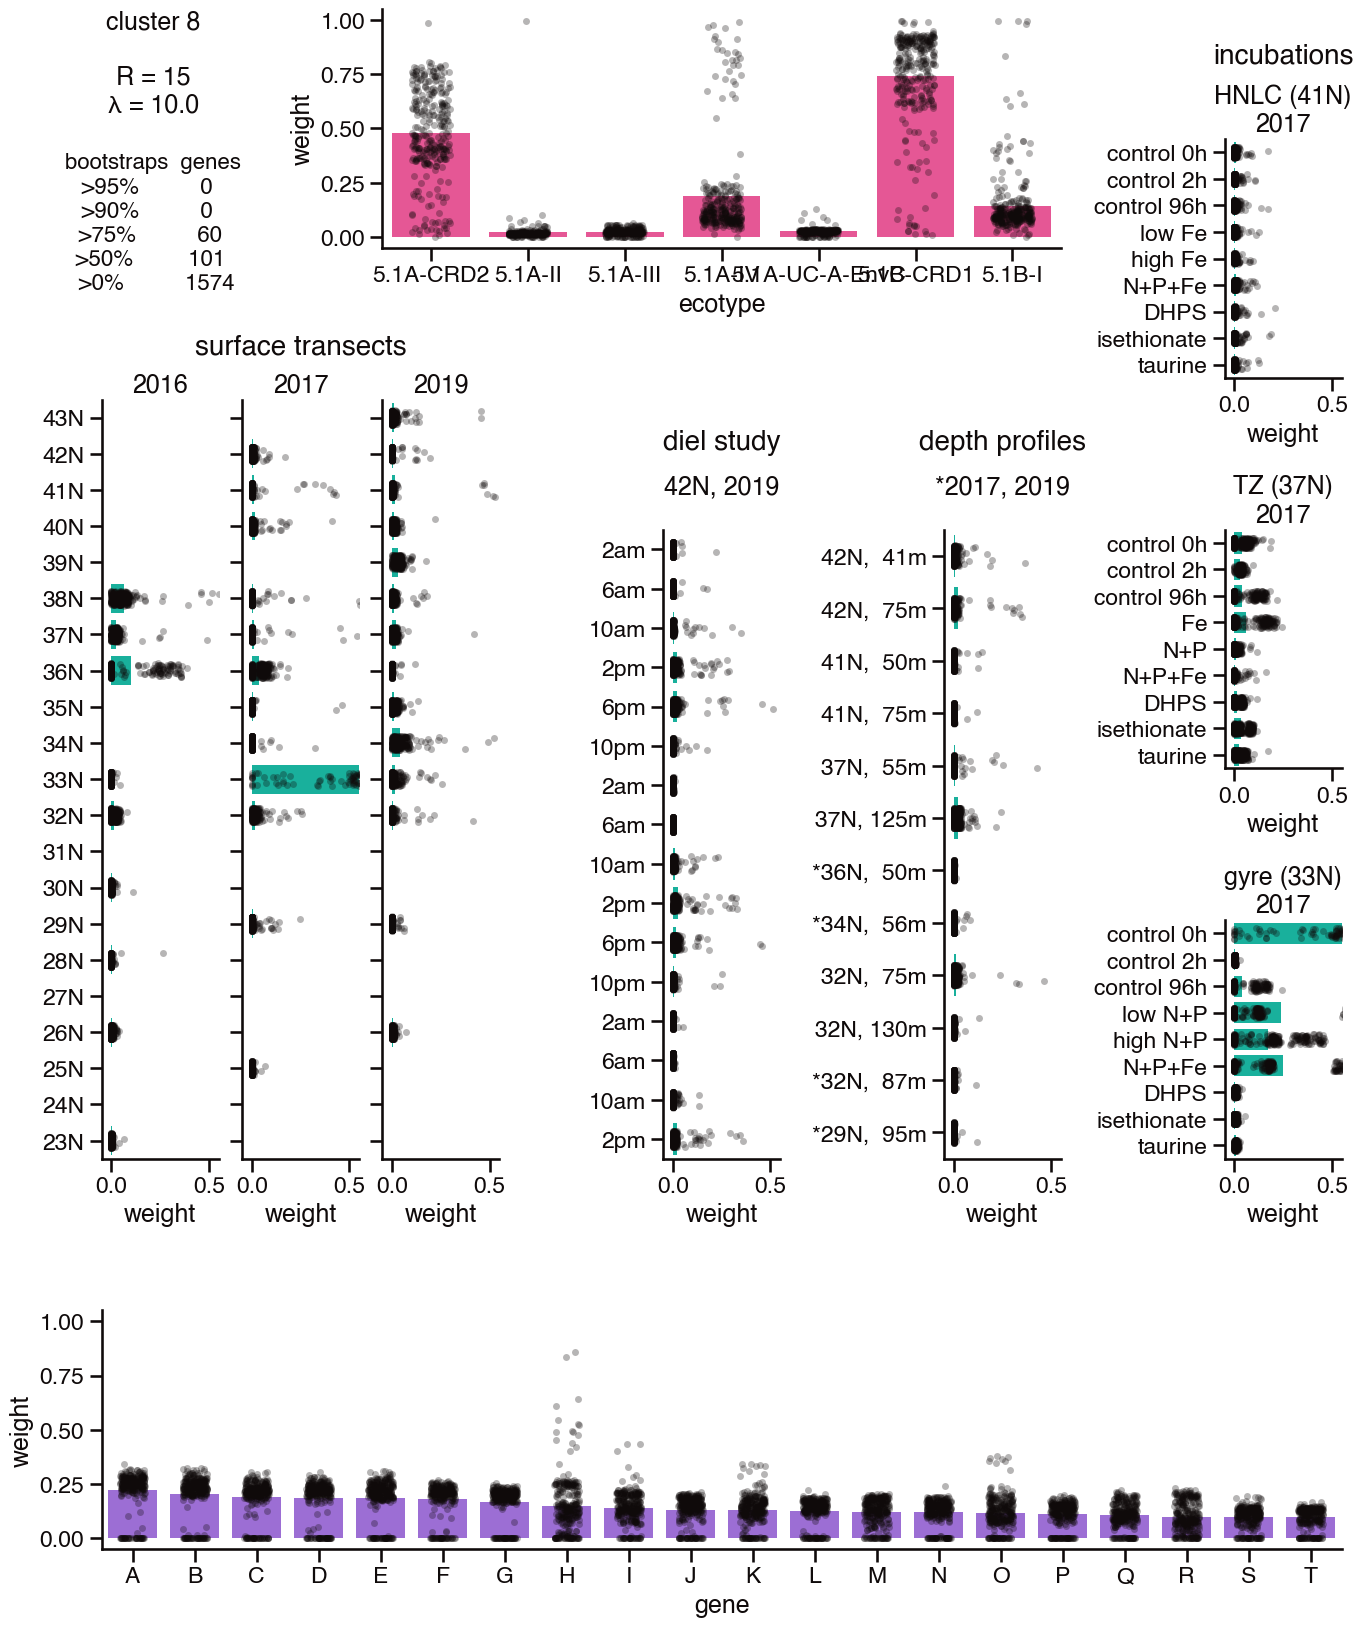

   gene     cycog                                         annotation  \
0     A  60000041                     cytochrome c oxidase subunit 1   
1     B  60000194   cytochrome c oxidase assembly protein subunit 15   
2     C  60000835       RNA polymerase sigma factor, sigma-70 family   
3     D  60000067                     cytochrome c oxidase subunit 2   
4     E  60000170                   protoheme IX farnesyltransferase   
5     F  60000247                       NADH dehydrogenase subunit M   
6     G  60000077                     cytochrome c oxidase subunit 3   
7     H  60000362                RNA polymerase primary sigma factor   
8     I  60000295                         sucrose-phosphate synthase   
9     J  60000595                                      transaldolase   
10    K  60002241                               hypothetical protein   
11    L  60000105  ATP-dependent Clp protease ATP-binding subunit...   
12    M  60001088  ferredoxin protochlorophyllide reductase subu

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


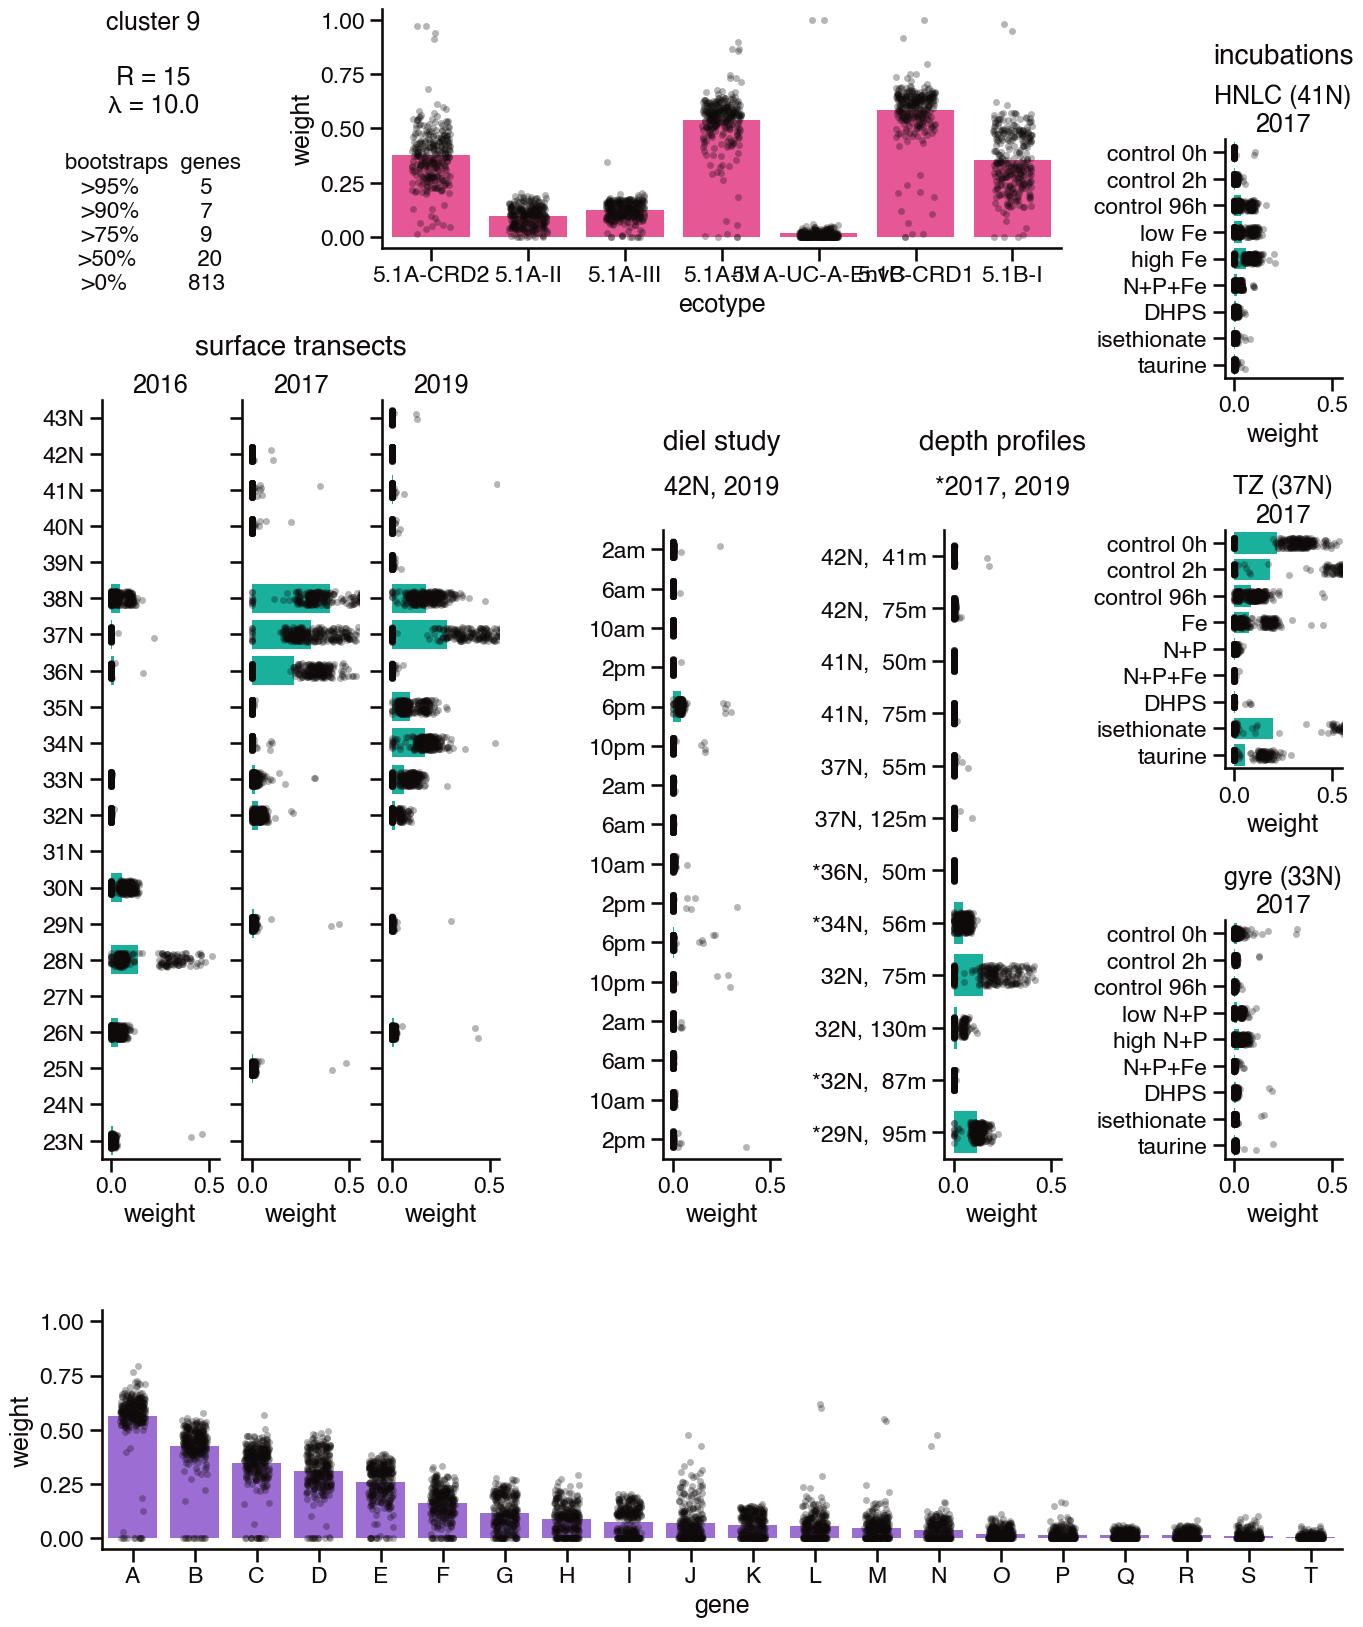

   gene     cycog                                         annotation  \
0     A  60001296                               urea-binding protein   
1     B  60001803                        formate/nitrite transporter   
2     C  60001886  MFS transporter, NNP family, nitrate/nitrite t...   
3     D  60001979                                      cyanate lyase   
4     E  60000113                               ammonium transporter   
5     F  60001560  assimilatory nitrite reductase (ferredoxin) pr...   
6     G  60001300              urea ABC transporter membrane protein   
7     H  60001877  assimilatory nitrate reductase (ferredoxin) pr...   
8     I  60002822               glucosyl-3-phosphoglycerate synthase   
9     J  60001535              protein of unknown function (DUF4278)   
10    K  60001295              urea ABC transporter membrane protein   
11    L  60004264  Succinate dehydrogenase/fumarate reductase, fl...   
12    M  60004141                                        HEAT re

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


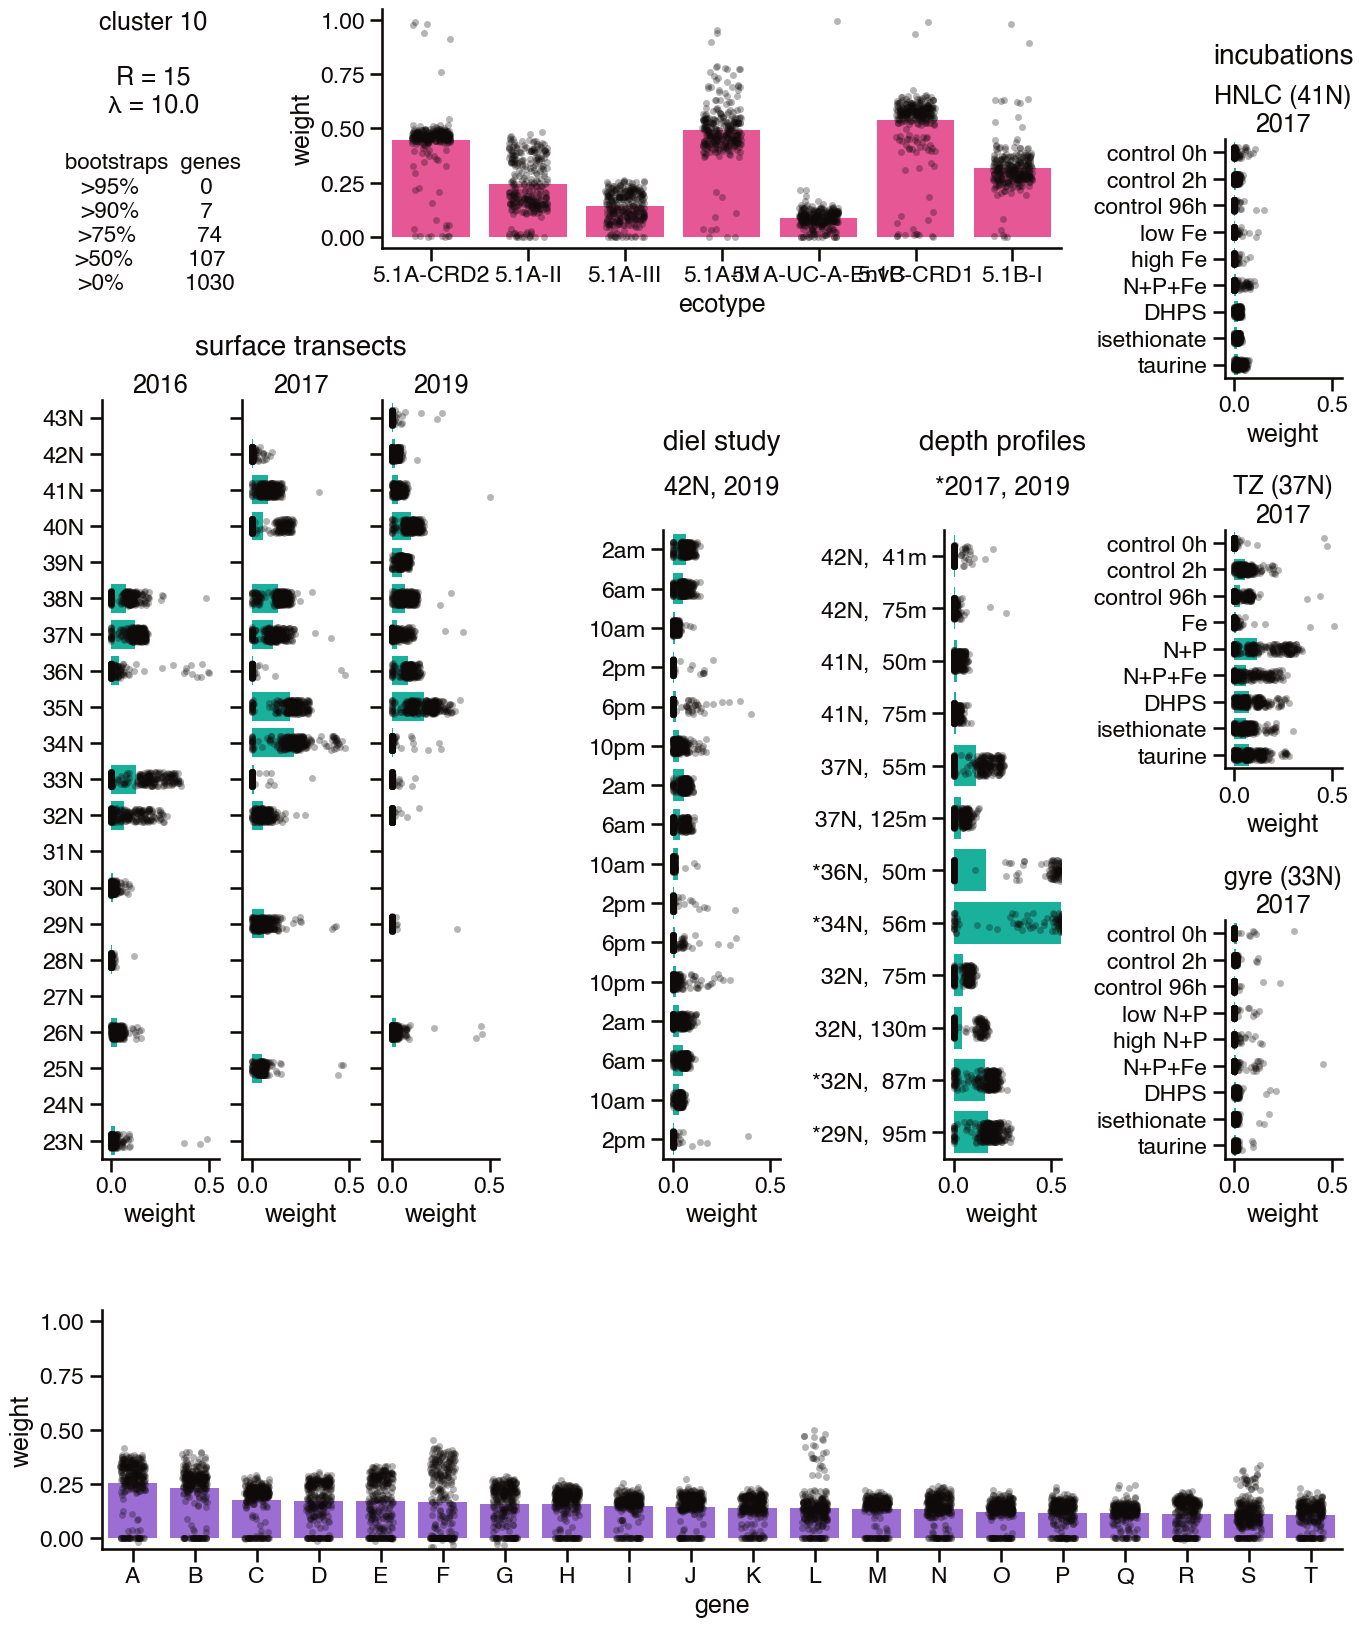

   gene     cycog                                         annotation  \
0     A  60000978  ribulose 1,5-bisphosphate carboxylase large su...   
1     B  60000836  D-fructose 1,6-bisphosphatase /sedoheptulose 1...   
2     C  60001081  ribulose 1,5-bisphosphate carboxylase small su...   
3     D  60000742              ATP synthase F0 subcomplex B' subunit   
4     E  60000381   glyceraldehyde 3-phosphate dehydrogenase (NADP+)   
5     F  60001290                     fructose-bisphosphate aldolase   
6     G  60000273                            phosphoglycerate kinase   
7     H  60000979                      BMC domain-containing protein   
8     I  60000507           ATP synthase F1 subcomplex alpha subunit   
9     J  60000811               Carboxysome shell peptide mid-region   
10    K  60000726            F-type H+-transporting ATPase subunit b   
11    L  60000005                                   chaperonin GroEL   
12    M  60000138            ATP synthase F1 subcomplex beta sub

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


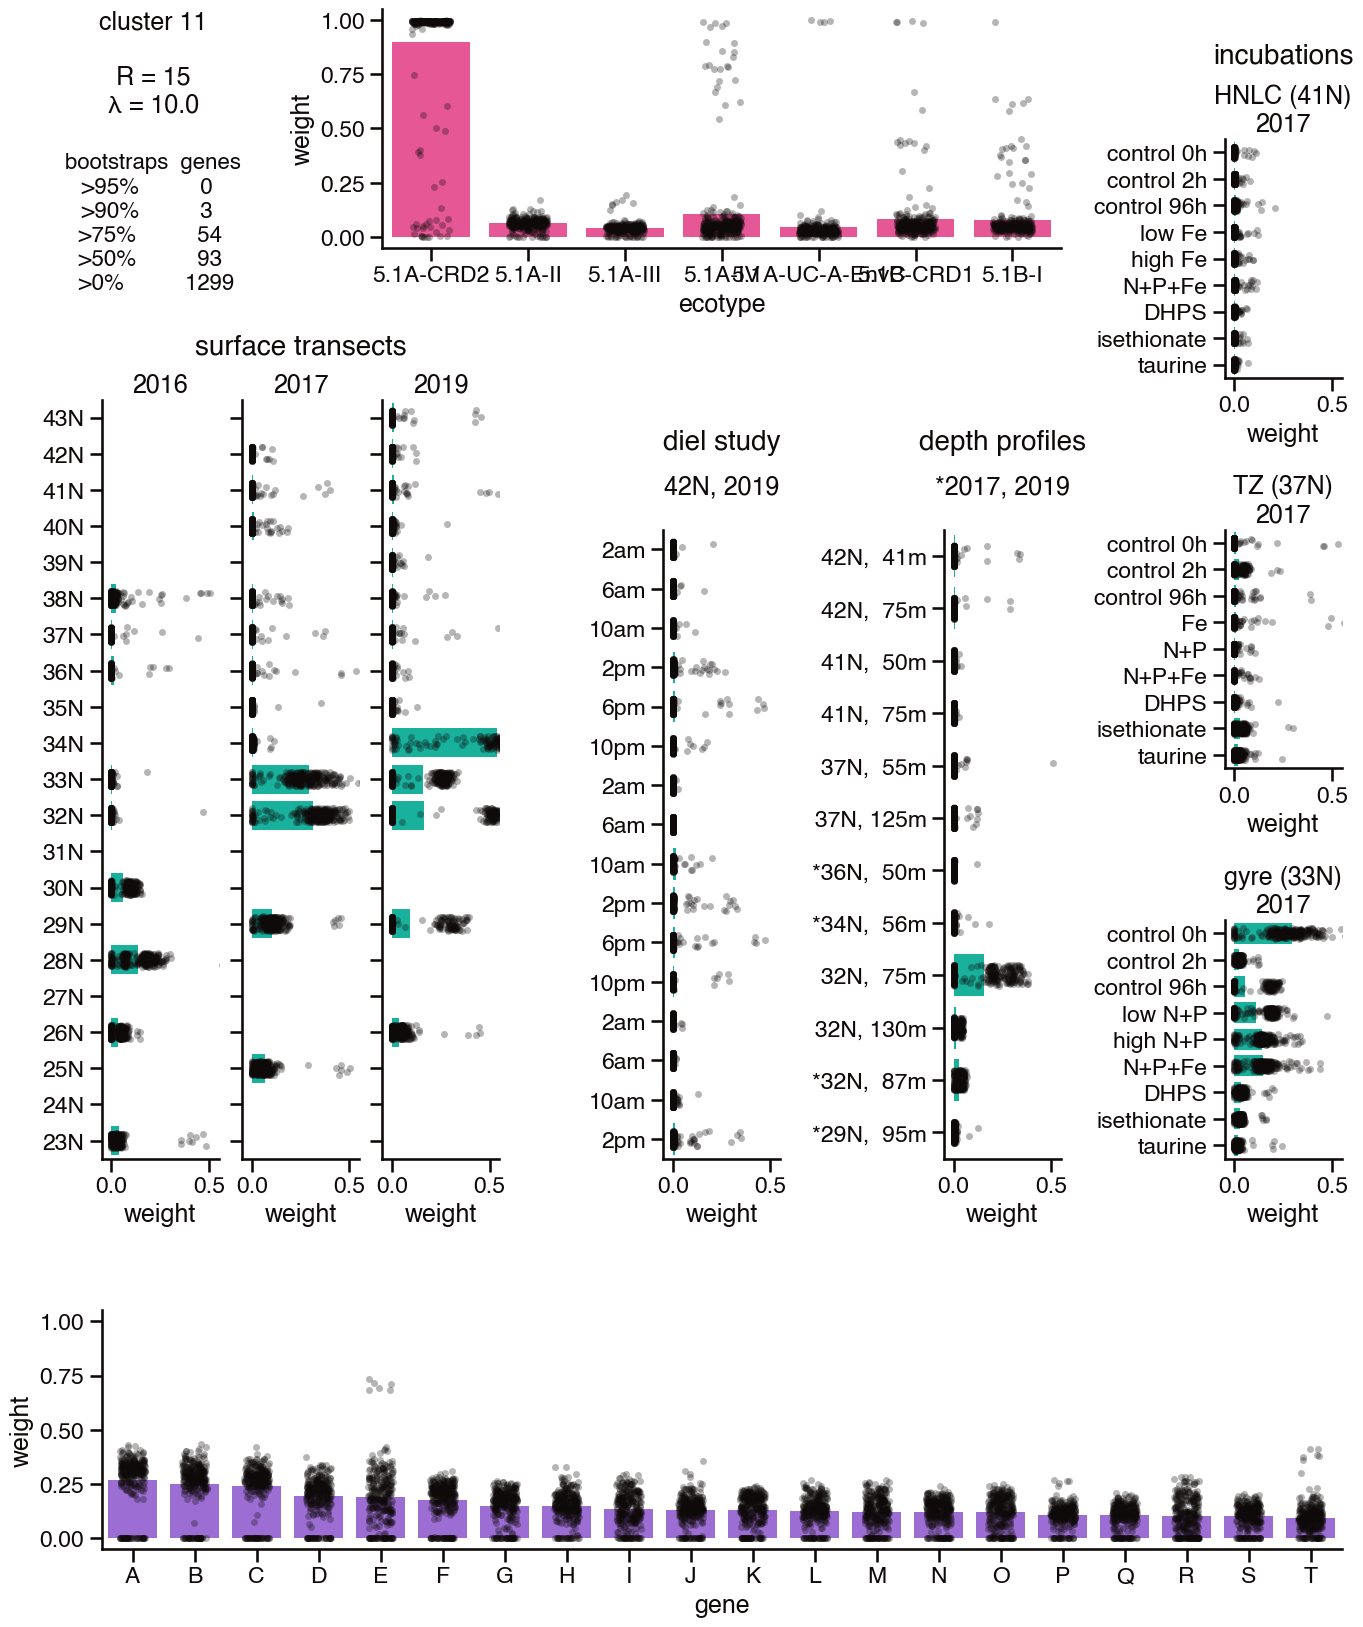

   gene     cycog                                         annotation  \
0     A  60030679                               hypothetical protein   
1     B  60004183                                        formamidase   
2     C  60004832                               hypothetical protein   
3     D  60004204              protein of unknown function (DUF4278)   
4     E  60005623                               hypothetical protein   
5     F  60005716                               hypothetical protein   
6     G  60003149                               hypothetical protein   
7     H  60000285                               hypothetical protein   
8     I  60000541                               hypothetical protein   
9     J  60000032     photosystem II P680 reaction center D1 protein   
10    K  60010252                               hypothetical protein   
11    L  60004884                               hypothetical protein   
12    M  60002944                       MscS family membrane pro

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


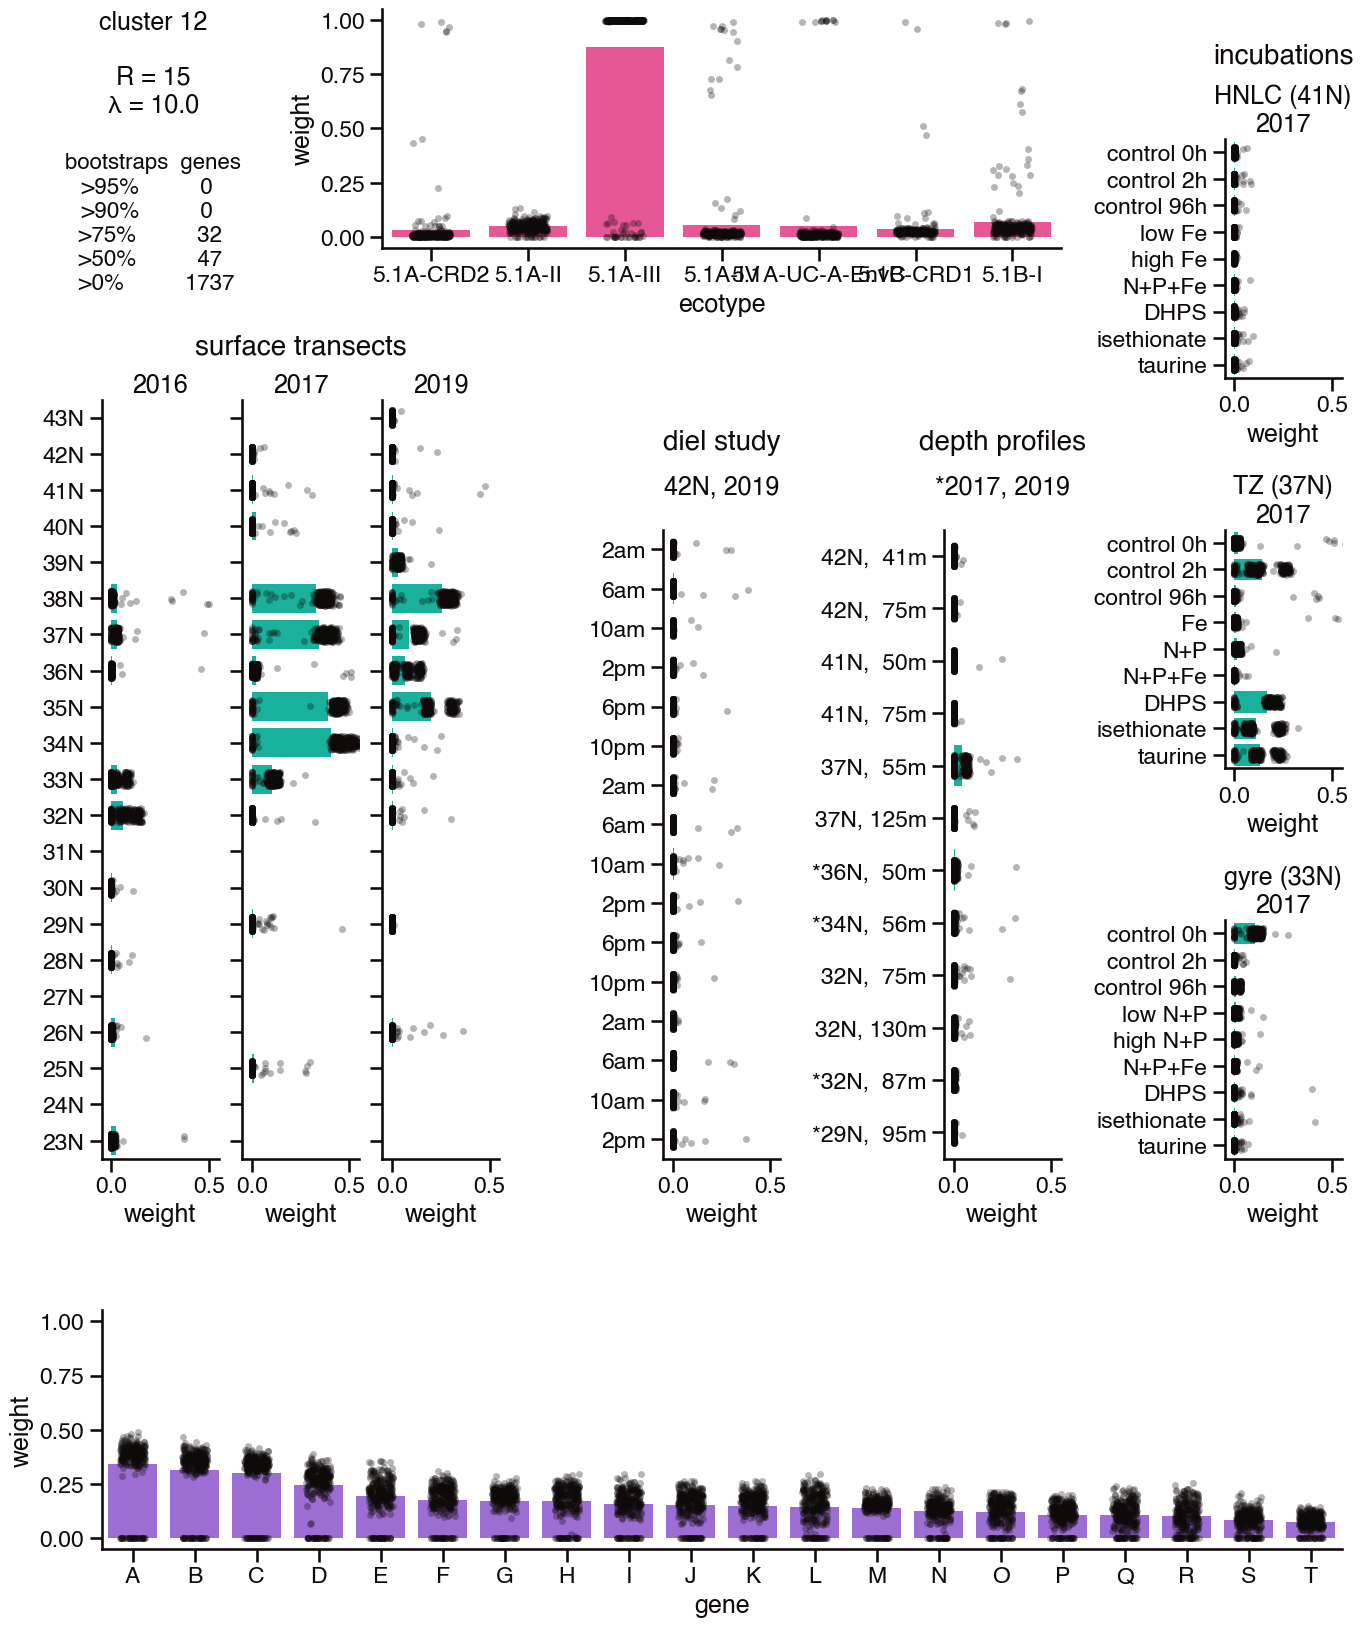

   gene     cycog                                         annotation  \
0     A  60009898  Predicted O-linked N-acetylglucosamine transfe...   
1     B  60004866                  ATP-binding cassette, subfamily B   
2     C  60011407               Domain of unknown function (DUF4915)   
3     D  60004369  Glycosyltransferase involved in cell wall bisy...   
4     E  60001471       polysaccharide export outer membrane protein   
5     F  60001332                         GDPmannose 4,6-dehydratase   
6     G  60000308                           aspartyl-tRNA synthetase   
7     H  60000933                             quinolinate synthetase   
8     I  60003260  Glycosyltransferase sugar-binding region conta...   
9     J  60001495  NDP-sugar epimerase, includes UDP-GlcNAc-inver...   
10    K  60001932  2-dehydro-3-deoxyphosphooctonate aldolase (KDO...   
11    L  60000102                   protein translocase subunit secA   
12    M  60003211                         LSU ribosomal protein 

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


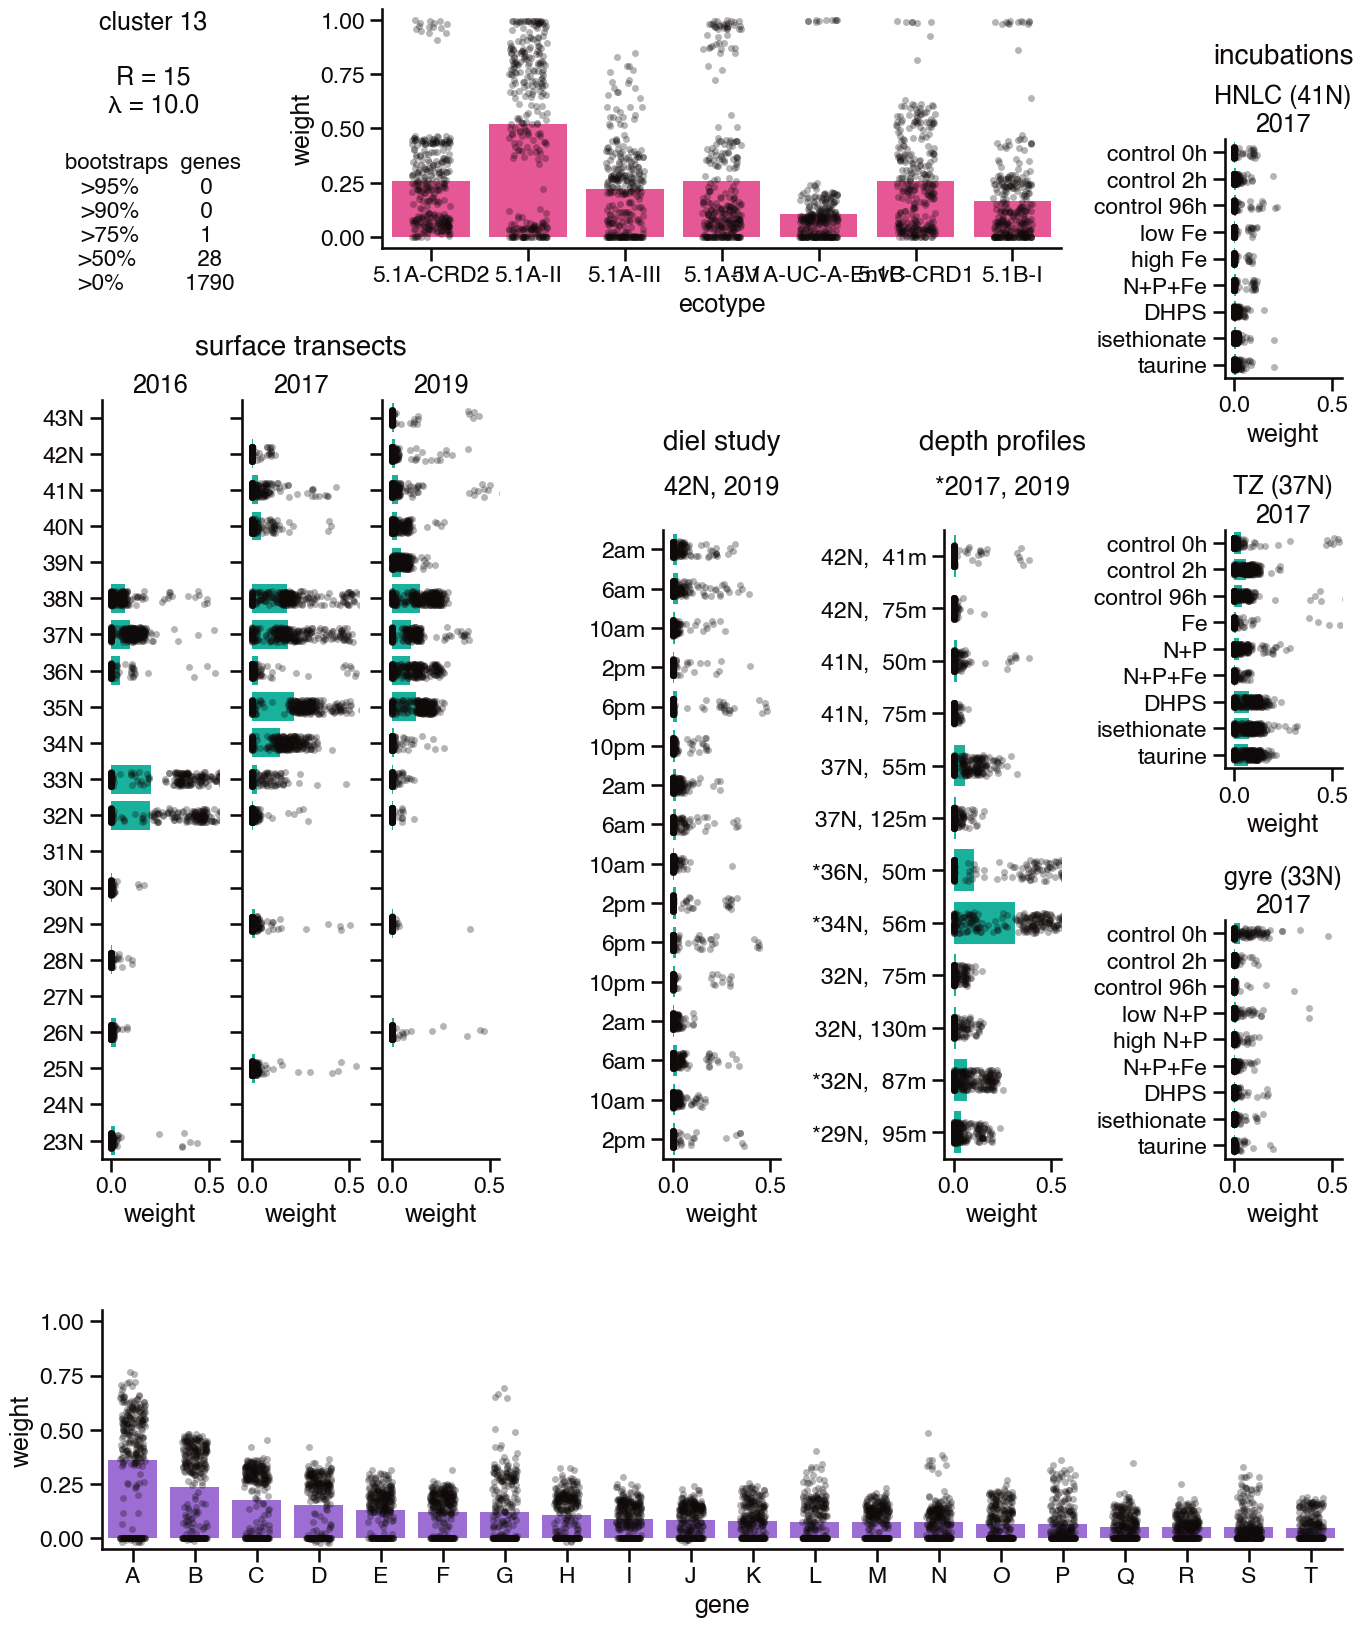

   gene     cycog                                         annotation  \
0     A  60001290                     fructose-bisphosphate aldolase   
1     B  60000381   glyceraldehyde 3-phosphate dehydrogenase (NADP+)   
2     C  60000742              ATP synthase F0 subcomplex B' subunit   
3     D  60000273                            phosphoglycerate kinase   
4     E  60000624               ATP synthase F0 subcomplex A subunit   
5     F  60000979                      BMC domain-containing protein   
6     G  60000836  D-fructose 1,6-bisphosphatase /sedoheptulose 1...   
7     H  60000691                                phosphoribulokinase   
8     I  60000308                           aspartyl-tRNA synthetase   
9     J  60000321                          inorganic pyrophosphatase   
10    K  60001081  ribulose 1,5-bisphosphate carboxylase small su...   
11    L  60000833               ATP synthase F0 subcomplex C subunit   
12    M  60000049        translation elongation factor 2 (EF-2/E

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


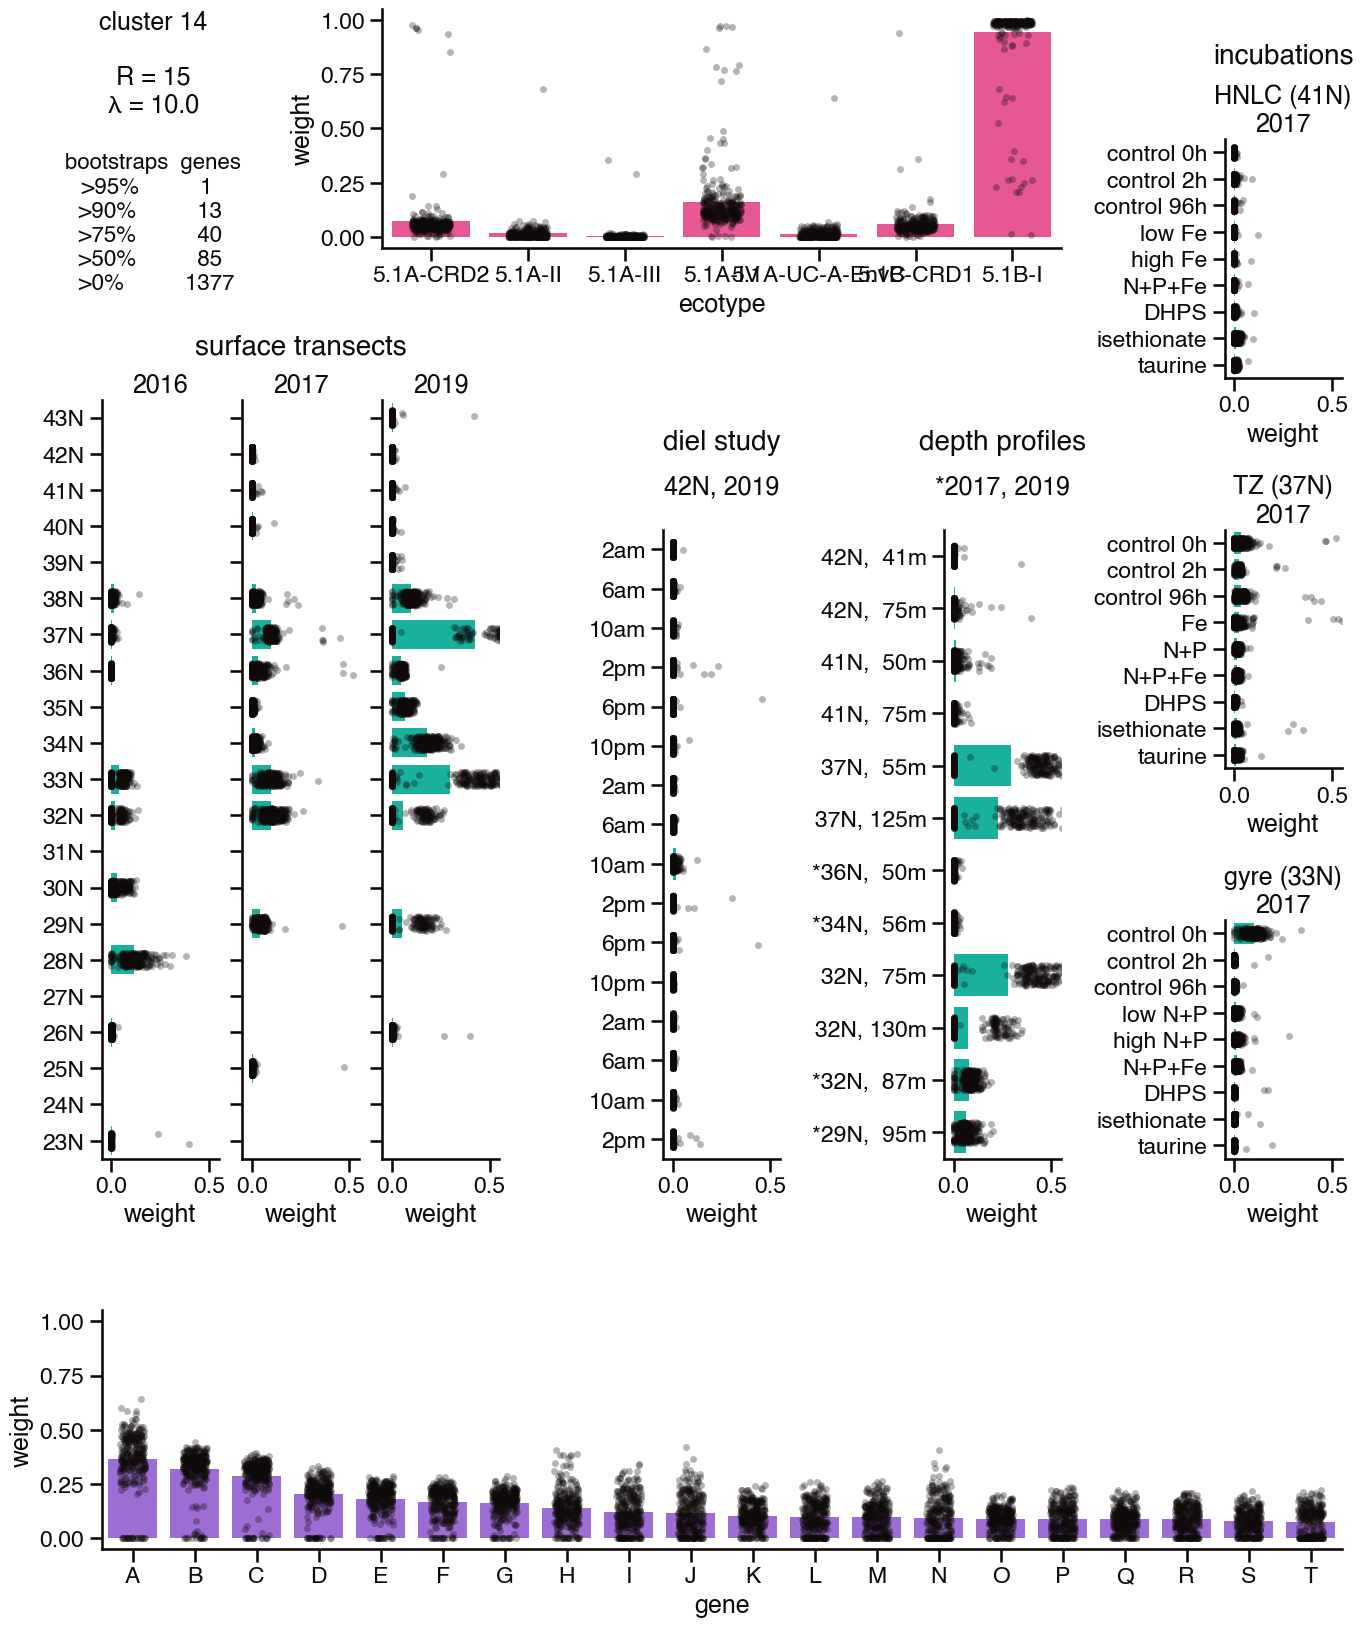

   gene     cycog                                         annotation  \
0     A  60001007                                           Ferritin   
1     B  60001666                             ATP synthase protein I   
2     C  60000624               ATP synthase F0 subcomplex A subunit   
3     D  60002711         phycobilisome core-membrane linker protein   
4     E  60006037                               hypothetical protein   
5     F  60001240                               hypothetical protein   
6     G  60006409                           photosystem I subunit 10   
7     H  60002794      Nitrogen fixation protein of unknown function   
8     I  60003427  transport factor 2 (NTF2) domain-containing pr...   
9     J  60002649                               HSP20 family protein   
10    K  60002856                                      Peroxiredoxin   
11    L  60000519                               hypothetical protein   
12    M  60001886  MFS transporter, NNP family, nitrate/nitrite 

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_88045/1920939089.py:165: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]


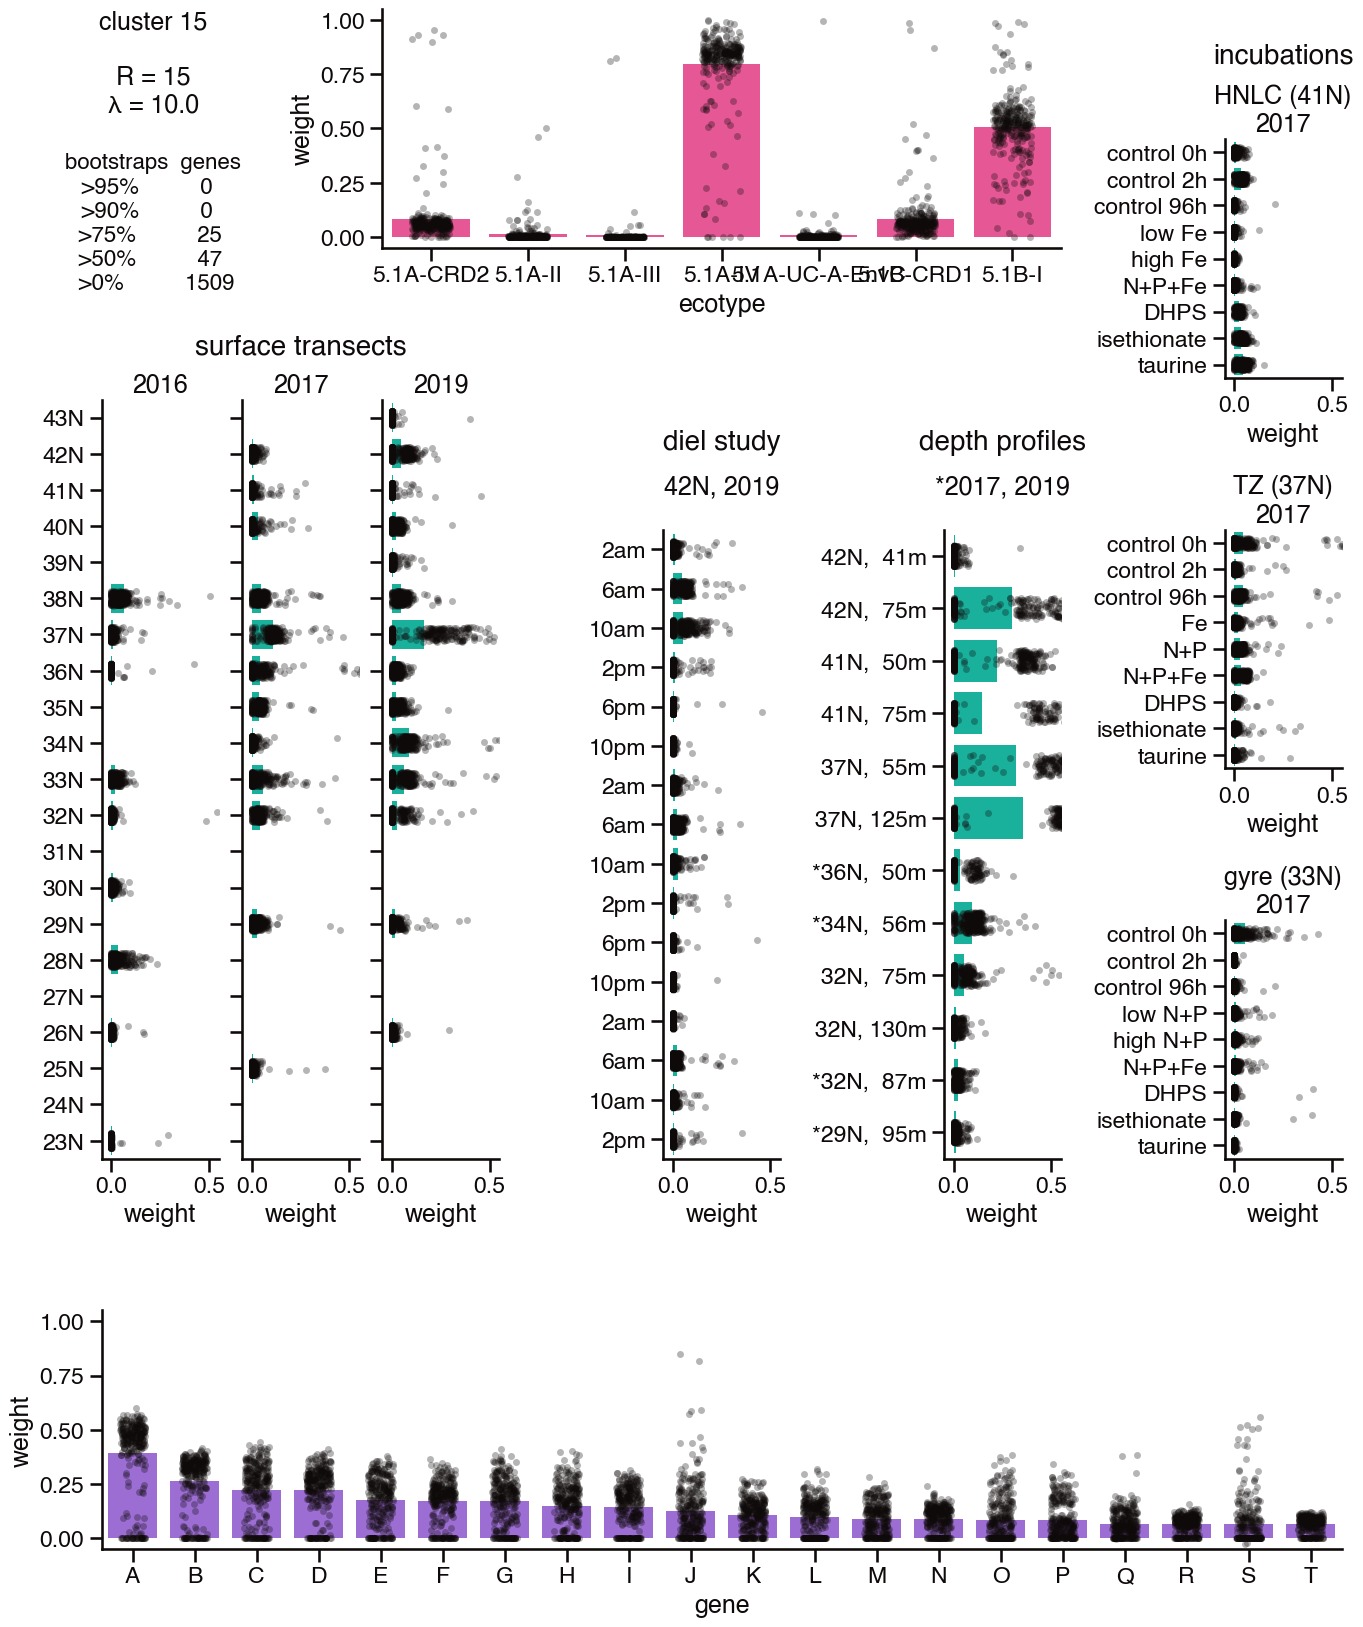

   gene     cycog                                         annotation  \
0     A  60002794      Nitrogen fixation protein of unknown function   
1     B  60002624                     HEAT repeat-containing protein   
2     C  60003153                               hypothetical protein   
3     D  60001433                               hypothetical protein   
4     E  60003427  transport factor 2 (NTF2) domain-containing pr...   
5     F  60003368                               hypothetical protein   
6     G  60002769                               hypothetical protein   
7     H  60001287                     fructose-bisphosphate aldolase   
8     I  60003618  nif11-like leader peptide domain-containing pr...   
9     J  60001535              protein of unknown function (DUF4278)   
10    K  60003202                               hypothetical protein   
11    L  60000449                RNA polymerase primary sigma factor   
12    M  60002712                                   PhoH-like AT

In [7]:
# make cluster plots
thold_bootstrap = 0.5 # only include genes in which at least this proportion of bootstraps include them in cluster

# iterate through interesting clusters
for cluster in clusters:
    
    # arrange gene data
    labels = tensor_ds.Ortholog.data
    annotations = tensor_ds.Annotation.data
    annotation_dict = dict(zip(labels, annotations))
    data = []
    for boot in bootstraps:
        for rep in replicates:
            cp = aligned_cps[boot][rep]
            weights = SparseCPTensor(cp).get_components()[cluster-1].factors[0].flatten()
            support = (weights != 0)
            data.append({
                'bootstrap': boot, 
                'replicate': rep, 
                **dict(zip(labels[support], weights[support]))
            })
    gene_df = pd.DataFrame(data).melt(id_vars=['bootstrap', 'replicate'], var_name='cycog', value_name='weight')
    counts = gene_df.groupby('cycog').weight.count()
    gene_df['% bootstraps'] = gene_df['cycog'].map(counts) / (len(bootstraps) * len(replicates))
    gene_df['annotation'] = gene_df['cycog'].map(annotation_dict)

    # arrange taxon data
    labels = tensor_ds.Clade.data
    data = []
    for boot in bootstraps:
        for rep in replicates:
            cp = aligned_cps[boot][rep]
            weights = SparseCPTensor(cp).get_components()[cluster-1].factors[1].flatten()
            data.append({
                'bootstrap': boot, 
                'replicate': rep, 
                **dict(zip(labels, weights))
            })
    taxon_df = pd.DataFrame(data).melt(id_vars=['bootstrap', 'replicate'], var_name='ecotype', value_name='weight')

    # arrange sample data
    data = []
    labels = tensor_ds.SampleName.data
    for boot in bootstraps:
        for rep in replicates:
            labels = samplenames[boot][rep]
            cp = aligned_cps[boot][rep]
            weights = SparseCPTensor(cp).get_components()[cluster-1].factors[2].flatten()
            data.append({
                'bootstrap': boot, 
                'replicate': rep, 
                **dict(zip(labels, weights))
            })
    sample_df = pd.DataFrame(data).melt(id_vars=['bootstrap', 'replicate'], var_name='samplename', value_name='weight')
    sample_df = pd.merge(left=sample_df, right=metadata_sample_df, on='samplename', how='outer')
    sample_df = sample_df.fillna(0)
    
    # plot figure
    max_genes = 20 # show top n genes only in figure (sorted by weight)
    sample_weight_range = (-0.05, 0.55) # range of weights to show on sample plots
    fig = plt.figure(figsize=(16, 20))
    rows = 12
    cols = 9
    grid = plt.GridSpec(rows, cols, wspace=.2, hspace=.2)
    annot_kwgs = {
        'xycoords': 'axes fraction', 'va': 'center', 'ha': 'left', 'fontsize': 22, 'annotation_clip': False
    }
    incubation_treatment_order = {
        'HNLC': ['control 0h', 'control 2h', 'control 96h', 'low Fe', 'high Fe', 'N+P+Fe', 'DHPS', 'isethionate', 'taurine'], 
        'TZ': ['control 0h', 'control 2h', 'control 96h', 'Fe', 'N+P', 'N+P+Fe', 'DHPS', 'isethionate', 'taurine'], 
        'gyre': ['control 0h', 'control 2h', 'control 96h', 'low N+P', 'high N+P', 'N+P+Fe', 'DHPS', 'isethionate', 'taurine']
    }

    # helper function for plotting weights as barplot with datapoints scattered on top
    def plot_weights(df, x, y, ax, order=None, color=sns.color_palette()[0], orient='v'):
        sns.barplot(
            data=df, x=x, y=y, color=color, orient=orient, order=order, errorbar=None, ax=ax
        )
        sns.stripplot(
            data=df, x=x, y=y, color=line_color, alpha=.3, size=5, jitter=.2, orient=orient, order=order, ax=ax
        ) 

    # annotate with information about the cluster
    boot_stats = gene_df.groupby('cycog')['% bootstraps'].mean()
    axis = plt.subplot(grid[0:2, 0:2])
    axis.set_axis_off()
    axis.annotate(
        'cluster {}\n\nR = {}\nλ = {}'.format(cluster, rank, lamb), 
        xy=(0.2, 1.0), xycoords='axes fraction', va='top', ha='center', fontsize=18
    )
    axis.annotate(
        'bootstraps  genes\n{:^13}{:^12}\n{:^13}{:^12}\n{:^13}{:^12}\n{:^13}{:^12}\n{:^14}{:^12}'.format(
            '>95%', boot_stats.gt(0.95).sum(), '>90%', boot_stats.gt(0.9).sum(), '>75%', boot_stats.gt(0.75).sum(), 
            '>50%', boot_stats.gt(0.5).sum(), '>0%', boot_stats.gt(0.0).sum()), 
        xy=(0.2, 0.4), xycoords='axes fraction', va='top', ha='center', fontsize=16
    )

    # plot ecotype data
    axis = plt.subplot(grid[0:2, 2:7])
    # axis.annotate('A', xy=(-0.2, 1.15), **annot_kwgs)
    plot_weights(
        df=taxon_df, x='ecotype', y='weight', ax=axis, color=sns.color_palette()[3]
    )
    axis.set(ylim=[-0.05, 1.05])
    axis.tick_params(axis='x', labelrotation=0)


    # plot surface transect data
    n_bins = 21
    bounds = (23, 43)
    for i, year in enumerate([2016, 2017, 2019]):
        axis = plt.subplot(grid[3:9, i])
        if i == 1:
            axis.annotate('surface transects', xy=(.5, 1.07), xycoords='axes fraction', 
                          va='center', ha='center', fontsize=20)
    #         axis.annotate('A', xy=(-0.2, 1.15), **annot_kwgs)
        # get data together
        plot_df = sample_df[sample_df['samplegroup'] == 'surface transect']
        plot_df = plot_df[plot_df['year'] == year]
        latitudes = plot_df[
            ['samplename', 'latitude']].drop_duplicates().set_index('samplename').sort_values('latitude')['latitude']
        lat_bins = unique_bins(latitudes, n_bins, bounds=bounds, reverse=True)
        plot_df['lat_idx'] = plot_df['samplename'].map(dict(zip(latitudes.index, lat_bins)))
        # make figure
        plot_weights(
            df=plot_df, x='weight', y='lat_idx', ax=axis, order=np.arange(n_bins), 
            color=sns.color_palette()[2], orient='h'
        )
        # set labels and such
        axis.set(xlim=sample_weight_range, ylabel='', xlabel='weight', title=year)
        if not i:
            axis.set_yticks(np.arange(n_bins), [f'{int(l)}N' for l in np.linspace(bounds[1], bounds[0], num=n_bins)])
        else:
            axis.tick_params(left=True, labelleft=False)

    # plot diel data
    axis = plt.subplot(grid[4:9, 4])
    # axis.annotate('B', xy=(-0.2, 1.15), **annot_kwgs)
    axis.annotate('diel study', xy=(0.5, 1.14), xycoords='axes fraction', va='center', ha='center', fontsize=20)
    # get data together
    plot_df = sample_df[sample_df['samplegroup'] == 'diel study'].sort_values('datetime')
    n_samples = plot_df['samplename'].nunique()
    plot_df['idx'] = plot_df['samplename'].map(dict(zip(plot_df['samplename'].unique(), np.arange(n_samples))))
    plot_weights(
        df=plot_df, x='weight', y='idx', ax=axis, color=sns.color_palette()[2], orient='h'
    )
    axis.set(xlim=sample_weight_range, ylabel='', title='42N, 2019\n')
    axis.set_yticks(np.arange(n_samples), plot_df[['samplename', 'timeclass']].drop_duplicates()['timeclass']);

    # plot depth data
    axis = plt.subplot(grid[4:9, 6])
    # axis.annotate('B', xy=(-0.2, 1.15), **annot_kwgs)
    axis.annotate('depth profiles', xy=(0.5, 1.14), xycoords='axes fraction', va='center', ha='center', fontsize=20)
    # get data together
    plot_df = sample_df[sample_df['samplegroup'] == 'depth profiles'].sort_values(
        ['latitude', 'depth'], ascending=[False, True])
    n_samples = plot_df['samplename'].nunique()
    plot_df['idx'] = plot_df['samplename'].map(dict(zip(plot_df['samplename'].unique(), np.arange(n_samples))))
    plot_weights(
        df=plot_df, x='weight', y='idx', ax=axis, color=sns.color_palette()[2], orient='h'
    )
    axis.set(xlim=sample_weight_range, ylabel='', title='*2017, 2019\n')
    label_df = plot_df[['samplename', 'depth', 'latitude', 'year']].drop_duplicates()
    year_dict = {2017: '*', 2019: ''}
    labels = [f'{year_dict[r[3]]}{int(r[2])}N,{r[1]:4}m' for _, r in label_df.iterrows()]
    axis.set_yticks(np.arange(n_samples), labels);

    # plot incubation data
    for i, condition in enumerate(['HNLC', 'TZ', 'gyre']):
        axis = plt.subplot(grid[3*i+1:3*(i+1), 8])
        if not i:
            axis.annotate('incubations', xy=(0.5, 1.35), xycoords='axes fraction', 
                          va='center', ha='center', fontsize=20)
        # get data together
        plot_df = sample_df[sample_df['condition'] == condition]
        plot_weights(
            df=plot_df, x='weight', y='treatment', ax=axis, color=sns.color_palette()[2], 
            order=incubation_treatment_order[condition], orient='h'
        )
        axis.set(xlim=sample_weight_range, ylabel='', 
                 title='{} ({})\n2017'.format(condition, {'HNLC': '41N', 'TZ': '37N', 'gyre': '33N'}[condition]))


    # plot gene data
    axis = plt.subplot(grid[10:, :])
    # axis.annotate('E', xy=(-0.2, 1.15), **annot_kwgs)
    plot_df = gene_df[gene_df['% bootstraps'].ge(thold_bootstrap)]
    # fill in nas
    plot_df = plot_df.fillna(0.0)
    # find top genes by mean weight
    top_genes = plot_df.groupby('cycog').weight.mean().sort_values(ascending=False).head(max_genes).index
    plot_df = plot_df[plot_df['cycog'].isin(top_genes)].reset_index()
    # sort by mean weight
    gene_labels = list(string.ascii_uppercase)[:max_genes]
    plot_df['gene'] = plot_df['cycog'].map(dict(zip(top_genes, gene_labels)))
    plot_df = plot_df.sort_values('gene')
    # render plot
    plot_weights(
        df=plot_df, x='gene', y='weight', ax=axis, color=sns.color_palette()[0]
    )
    axis.set(ylim=[-0.05, 1.05])

    # save/show figure
    fig.savefig(outdir / '{}-profile-cluster{}.png'.format(genus, cluster), bbox_inches='tight')
    plt.show()

    # show gene name key after figure
    gene_key_df = gene_df.fillna(0.0).groupby(['cycog', 'annotation'])[['weight', '% bootstraps']].mean().reset_index()
    gene_key_df['gene'] = gene_key_df['cycog'].map(dict(zip(top_genes, gene_labels)))
    gene_key_df = gene_key_df[
        ['gene', 'cycog', 'annotation', 'weight', '% bootstraps']
    ].sort_values(['gene', '% bootstraps', 'weight'], ascending=[True, False, False]).reset_index(drop=True).fillna('')
    gene_key_df.to_csv(outdir / 'cluster{}.csv'.format(cluster), index=False)
    print(gene_key_df.head(50))
